# Housing Price Prediction Model using Ridge and Lasso regularization

## Introduction

In this notebook we are going to build regression model to predict the housing prices based on the data collected by the company from their australian market. The dataset contains various parameters defining the location, size, and other features of the houses and the house's price.

We are going to use Ridge and Lasso regularization methods to keep the model optimally fit and using Lasso we will also try to determine which insignificant predictors can be dropped.

The data is available in [train.csv](data/train.csv) and the data dictionary is in [data_dictionary.txt](data/data_dictionary.txt)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import  r2_score

import os
import warnings
warnings.filterwarnings('ignore')


## Data Exploration

In this section we will explore the dataset and will cleanup the columns / rows which are majority empty

In [2]:
housing = pd.read_csv("data/train.csv")
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
housing.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Analyze SalePrice

Lets analyze SalePrice column to see how the target variable's values are distributed and any outliers (using boxplot). This will give us good idea to take some decision of cleaning up columns or rows. 

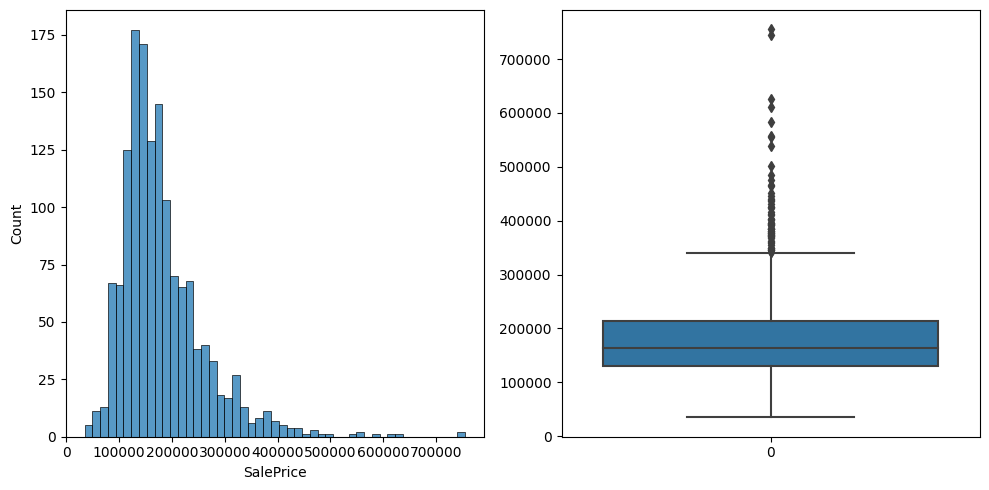

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [4]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.histplot(housing["SalePrice"], ax=axes[0])
sns.boxplot(housing["SalePrice"], ax=axes[1])
plt.show()
housing["SalePrice"].describe()

#### Analysis

The SalePrice has much larger values compared to rest of the data and though they seem to be normally distributed (although skewed on the lower tail) lets see whether the log of SalePrice is in better value range. The standard deviation is half than mean which is a good indicator of consistency in data.

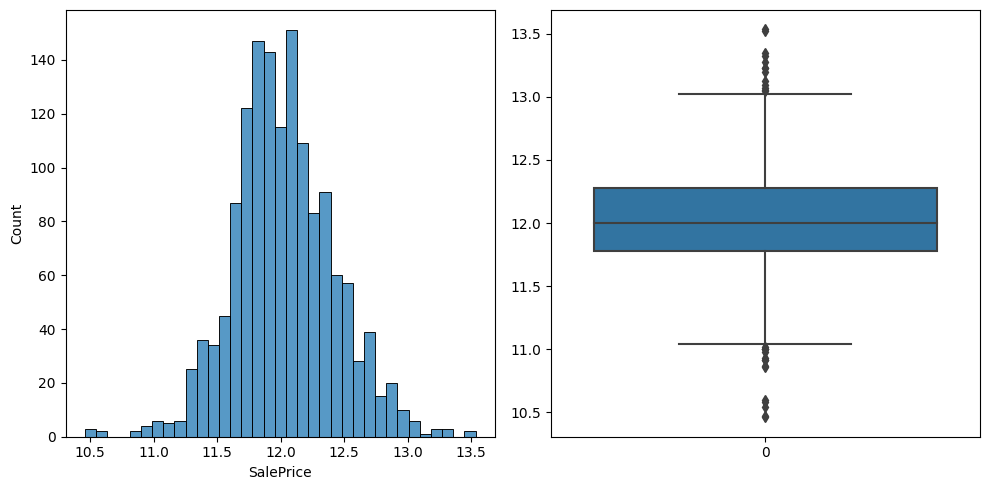

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [5]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.histplot(np.log(housing["SalePrice"]), ax=axes[0])
sns.boxplot(np.log(housing["SalePrice"]), ax=axes[1])
plt.show()
housing["SalePrice"].describe()

#### Summary

The log transform of SalePrice would be a better target variable to be considered so we will create a new column in the Data Transformation section.

### Removing empty/unwanted Columns & Rows

In [6]:
# Drop Id column
housing.drop(columns=['Id'],inplace=True)

In [7]:
# Find out the columns which are empty / NaN for more than 90% of rows, we can just drop them from the dataset
empty_cols = housing.columns[~(housing.isnull().sum(axis=0) <= housing.shape[0] * 0.9)].tolist()
housing.drop(columns=empty_cols,inplace=True)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [8]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

LotFrontage      259
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
Fence           1179
dtype: int64

In [9]:
# Fence has 1179 rows with NaN which is roughly 80% of total records and hence it can't be signficant for model building, so lets drop that column from the dataset
housing.drop(columns=['Fence'],inplace=True)                      

In [10]:
housing[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']][housing['GarageFinish'].isna()]

# there are 81 rows which have garage values as NaN we can just drop these rows from dataset
housing.drop(housing[['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']][housing['GarageFinish'].isna()].index,inplace=True)
housing.reset_index(drop=True, inplace=True)


In [11]:
housing['LotFrontage'].describe()

count    1127.000000
mean       70.683230
std        24.261598
min        21.000000
25%        60.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [12]:
# fill the missing values in LotFrontage to the mean of that column. It is the distance from street and given 75% is within 80 feet we can take mean which is 70 to fill the Null values
housing['LotFrontage'].fillna(housing['LotFrontage'].mean(), inplace=True)

In [13]:
# the stats are pretty much intact
housing['LotFrontage'].describe()

count    1379.000000
mean       70.683230
std        21.931281
min        21.000000
25%        60.000000
50%        70.683230
75%        79.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [14]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

MasVnrType        8
MasVnrArea        8
BsmtQual         30
BsmtCond         30
BsmtExposure     31
BsmtFinType1     30
BsmtFinType2     31
Electrical        1
FireplaceQu     618
dtype: int64

In [15]:
# FireplaceQu has almost **50% rows Null / NaN** so lets analyze the remain 50% rows have any strong correlation with SalePrice.
# Lets analyze first the distribution of the values in that column and then find the correlation.
    
housing['FireplaceQu'].value_counts()

Gd    376
TA    310
Fa     33
Ex     24
Po     18
Name: FireplaceQu, dtype: int64

In [16]:
# generate dummy variables to find the correlation with SalePrice
fqdummy = pd.get_dummies(housing[~housing['FireplaceQu'].isna()][['FireplaceQu']], drop_first=True)
cp=pd.concat([fqdummy,housing[~housing['FireplaceQu'].isna()][['SalePrice']]],axis=1)
cp.corr()

,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_Po,FireplaceQu_TA,SalePrice
FireplaceQu_Fa,1.000000,-0.210404,-0.033139,-0.176516,-0.124060
FireplaceQu_Gd,-0.210404,1.000000,-0.153817,-0.819325,0.110838
FireplaceQu_Po,-0.033139,-0.153817,1.000000,-0.129043,-0.149835
FireplaceQu_TA,-0.176516,-0.819325,-0.129043,1.000000,-0.104177
SalePrice,-0.124060,0.110838,-0.149835,-0.104177,1.000000


In [17]:
# There is no strong correlation and therefore we can drop this entire column.
housing.drop(columns=['FireplaceQu'],inplace=True)
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0)

MasVnrType       8
MasVnrArea       8
BsmtQual        30
BsmtCond        30
BsmtExposure    31
BsmtFinType1    30
BsmtFinType2    31
Electrical       1
dtype: int64

In [18]:
housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0).index

Index(['MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical'],
      dtype='object')

In [19]:
# lets find out how many rows exist that have atleast one NaN value
housing[housing.isna().any(axis=1)][housing[housing.columns[housing.isna().sum() > 0]].isna().sum(axis = 0).index].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 17 to 1334
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MasVnrType    33 non-null     object 
 1   MasVnrArea    33 non-null     float64
 2   BsmtQual      11 non-null     object 
 3   BsmtCond      11 non-null     object 
 4   BsmtExposure  10 non-null     object 
 5   BsmtFinType1  11 non-null     object 
 6   BsmtFinType2  10 non-null     object 
 7   Electrical    40 non-null     object 
dtypes: float64(1), object(7)
memory usage: 2.9+ KB


In [20]:
# there are total 41 rows, which is around 3% of total records, hence we can drop these rows to make the dataset NaN free
print(f"Before dropping rows {housing.shape}")
print(f"No of NaN Values {housing.isna().sum().sum()}")
housing.drop(housing[housing.isna().any(axis=1)].index, inplace=True)
housing.reset_index(drop=True, inplace=True)
print(f"After dropping rows {housing.shape}")
print(f"No of NaN Values {housing.isna().sum().sum()}")


Before dropping rows (1379, 75)
No of NaN Values 169
After dropping rows (1338, 75)
No of NaN Values 0


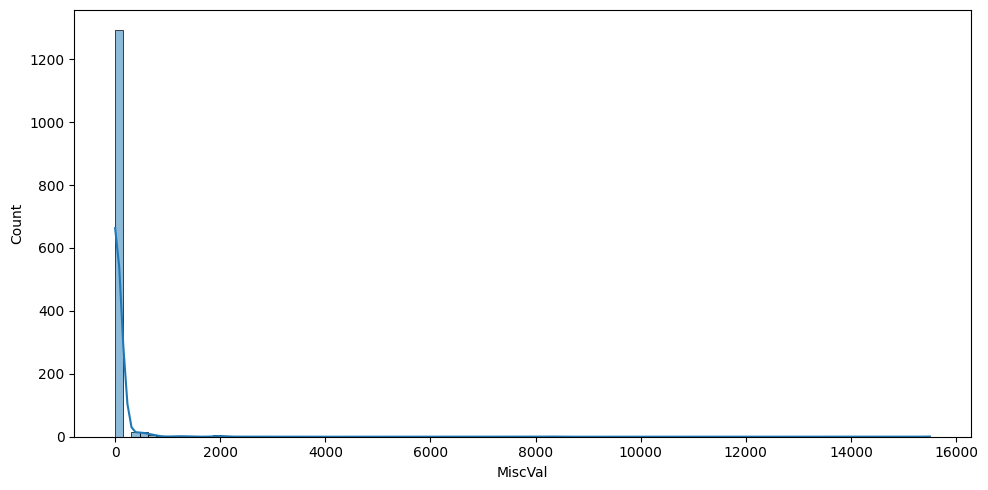

(47, 75)


In [21]:
# Analyze MiscVal column
sns.histplot(housing['MiscVal'], kde=True,bins=100)
plt.show()
print(housing[housing['MiscVal'] > 0].shape)

In [22]:
# There only 47 rows in this column have more than 0 amount. That is nearly 3% of total data and hence we can drop this column from our analysis.
housing.drop(columns=['MiscVal'],inplace=True)

### Analyze Categorical Data and Remove visibily insgnificant columns


In [23]:
for col in housing.select_dtypes(include=['object']).columns:
    print(f"### Column : {col} ###")
    print(housing[col].value_counts())
    print("\n")

### Column : MSZoning ###
RL         1066
RM          191
FV           62
RH           11
C (all)       8
Name: MSZoning, dtype: int64


### Column : Street ###
Pave    1333
Grvl       5
Name: Street, dtype: int64


### Column : LotShape ###
Reg    829
IR1    459
IR2     40
IR3     10
Name: LotShape, dtype: int64


### Column : LandContour ###
Lvl    1206
Bnk      52
HLS      48
Low      32
Name: LandContour, dtype: int64


### Column : Utilities ###
AllPub    1337
NoSeWa       1
Name: Utilities, dtype: int64


### Column : LotConfig ###
Inside     957
Corner     244
CulDSac     90
FR2         43
FR3          4
Name: LotConfig, dtype: int64


### Column : LandSlope ###
Gtl    1265
Mod      61
Sev      12
Name: LandSlope, dtype: int64


### Column : Neighborhood ###
NAmes      209
CollgCr    146
OldTown    100
Somerst     83
Gilbert     77
NridgHt     75
NWAmes      73
Edwards     70
Sawyer      69
SawyerW     53
Crawfor     50
BrkSide     47
Mitchel     42
NoRidge     41
Timber      37

#### Low Cardinality Columns and Cleanup

Upon visually inspecting the value counts distribution following columns can be easily ignored / dropped out of the main dataset. These columns have same values for more than 90% of records. Such variables can not describe the change in target variable's values.

* Street
* LandContour
* Utilities
* LandSlope
* Condition2
* RoofMatl

* CentralAir* BsmtCond
* Electrical
* Functional
* GarageQual
* GarageCond
* PavedDrive

In [24]:
# Lets drop these columns and create a new dataset (keeping housing as it is for any future reference)
print(housing.shape)
housing_cleaned = housing.drop(columns=['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl', 'BsmtCond', 'CentralAir','Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive'])
print(housing_cleaned.shape)

(1338, 74)
(1338, 61)


#### Mix Cardinality Columns and Cleanup

Following columns have one value which is much higher than others however less than 90% of records. We can spend some time to analyze their correlation with SalePrice to ensure that we are not dropping the columns without due analysis.

* LotConfig 
* Condition1 
* BldgType 
* ExterCond 
* BsmtFinType2 
* SaleType 
* SaleCondition 

In [25]:
for c in ['MSZoning','LotConfig', 'Condition1', 'BldgType', 'ExterCond', 'BsmtFinType2', 'SaleType', 'SaleCondition']:
    dummy = pd.get_dummies(housing[c])
    cp=pd.concat([dummy,np.log(housing['SalePrice'])],axis=1)
    print(f"### Column : {c} ####")
    print(cp.corr())
    print("")

### Column : MSZoning ####
            C (all)        FV        RH        RL        RM  SalePrice
C (all)    1.000000 -0.017096 -0.007061 -0.153537 -0.031649  -0.183645
FV        -0.017096  1.000000 -0.020069 -0.436380 -0.089951   0.108921
RH        -0.007061 -0.020069  1.000000 -0.180242 -0.037153  -0.083933
RL        -0.153537 -0.436380 -0.180242  1.000000 -0.807847   0.303286
RM        -0.031649 -0.089951 -0.037153 -0.807847  1.000000  -0.352230
SalePrice -0.183645  0.108921 -0.083933  0.303286 -0.352230   1.000000

### Column : LotConfig ####
             Corner   CulDSac       FR2       FR3    Inside  SalePrice
Corner     1.000000 -0.126824 -0.086057 -0.025861 -0.748479   0.000409
CulDSac   -0.126824  1.000000 -0.048934 -0.014705 -0.425606   0.147467
FR2       -0.086057 -0.048934  1.000000 -0.009978 -0.288797   0.006712
FR3       -0.025861 -0.014705 -0.009978  1.000000 -0.086785   0.019216
Inside    -0.748479 -0.425606 -0.288797 -0.086785  1.000000  -0.087144
SalePrice  0.000409  

##### Summary and Cleanup

As per visual inspection, except SaleCondition all other columns have negligible correlation with SalePrice.

For SaleCondition the correlation is weaker however in order to give benefit of doubt we will keep this column for now in the cleaned dataset. 

Other columns we will drop.

In [26]:
housing_cleaned.drop(columns=['LotConfig', 'Condition1', 'BldgType', 'ExterCond', 'BsmtFinType2'],inplace=True)

In [27]:
housing_cleaned.shape

(1338, 56)

### Inspect Numeric Category Columns

In [28]:
num_category_cols = ['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces']



for c in num_category_cols:
    print(f"#### Column : {c} ####")
    print(housing_cleaned[c].astype('category').value_counts())
    print("")


#### Column : MSSubClass ####
20     502
60     294
50     129
120     86
160     61
70      57
80      57
30      51
90      28
190     21
85      19
75      14
45       9
180      6
40       4
Name: MSSubClass, dtype: int64

#### Column : OverallQual ####
6     359
5     351
7     312
8     165
4      81
9      43
10     17
3       8
2       2
Name: OverallQual, dtype: int64

#### Column : OverallCond ####
5    770
6    233
7    183
8     68
4     46
9     20
3     15
2      3
Name: OverallCond, dtype: int64

#### Column : YearBuilt ####
2005    64
2006    63
2004    53
2007    46
2003    42
        ..
1917     1
1913     1
1912     1
1882     1
2010     1
Name: YearBuilt, Length: 109, dtype: int64

#### Column : YearRemodAdd ####
1950    145
2006     90
2005     71
2007     71
2004     60
       ... 
1983      5
1986      5
1982      5
1951      4
1952      4
Name: YearRemodAdd, Length: 61, dtype: int64

#### Column : MoSold ####
6     235
7     215
5     187
4     127
8     112
3  

#### Summary
Except BsmtHalfBath and KitchenAbvGr columns all the other columns are well distributed. We can drop these columns from our dataset for analysis.

In [29]:
print(f"Before : {housing_cleaned.shape}")
housing_cleaned.drop(columns=['BsmtHalfBath','KitchenAbvGr'], inplace=True)
print(f"After : {housing_cleaned.shape}")

Before : (1338, 56)
After : (1338, 54)


### Analyze pure numeric columns

In [30]:
# list the numeric columns
housing_cleaned.select_dtypes(include=['float64', 'int64']).columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [31]:
# after removing the columns which are numeric but categorical, following are the columns which are numeric
numeric_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                'GrLivArea', 'BsmtFullBath',  'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea']


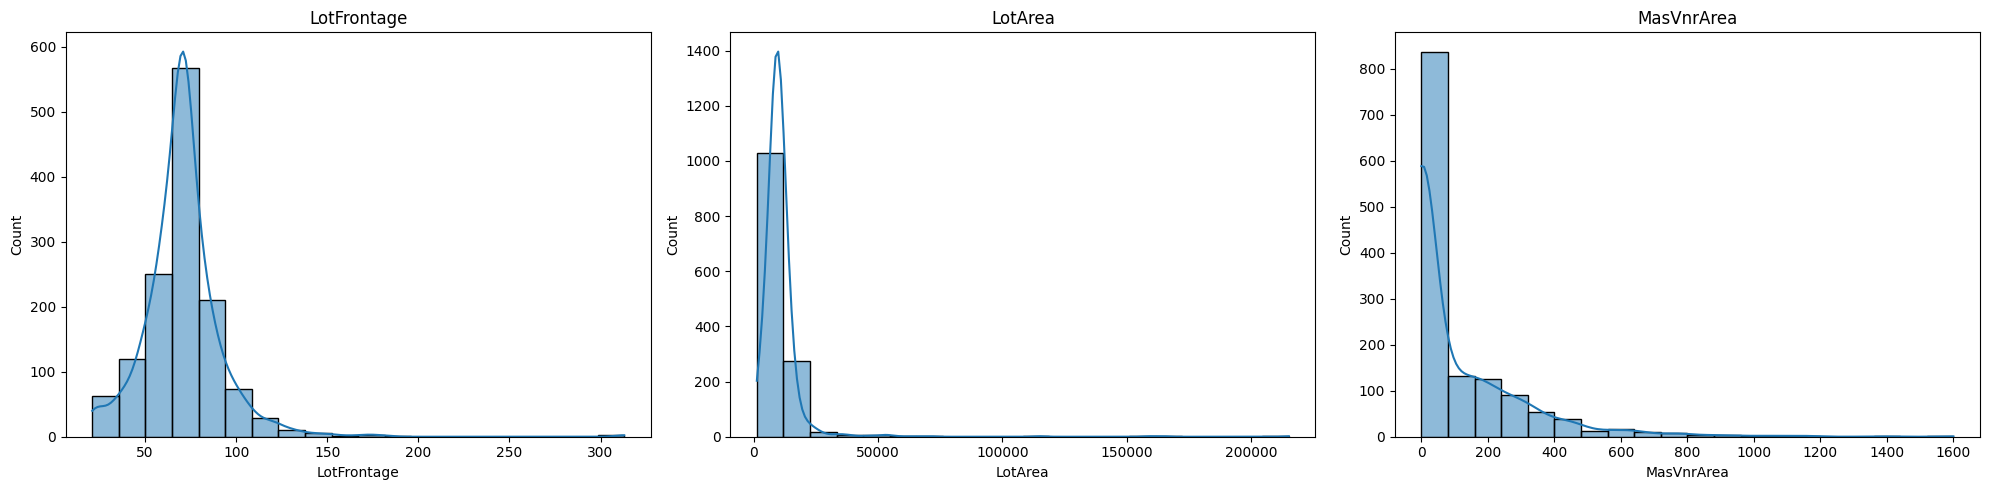

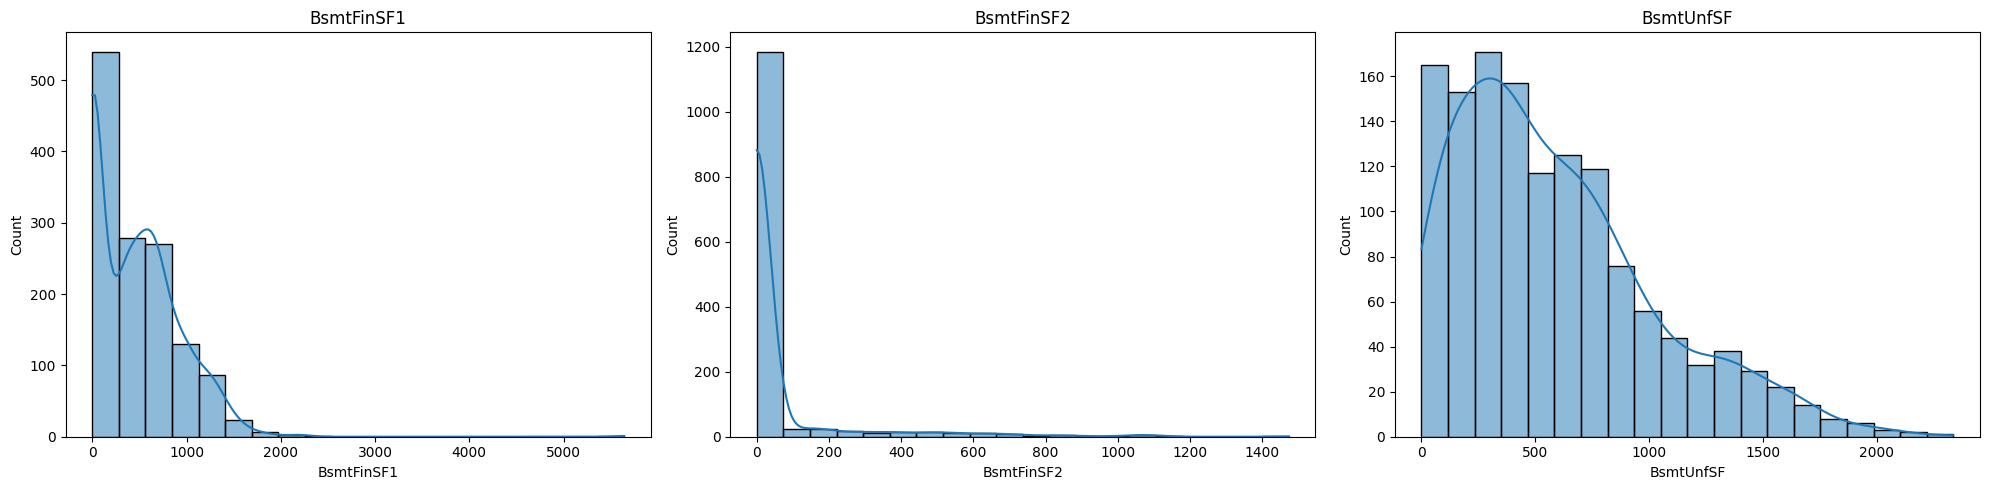

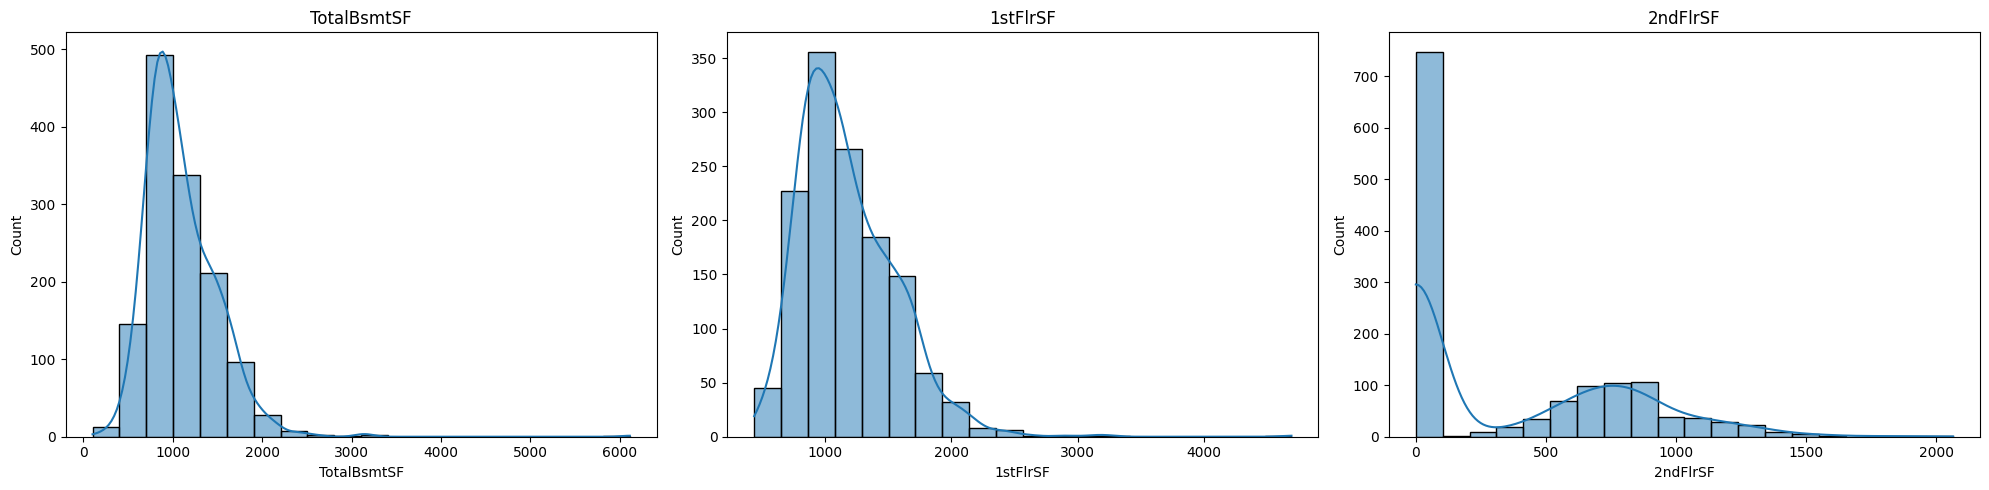

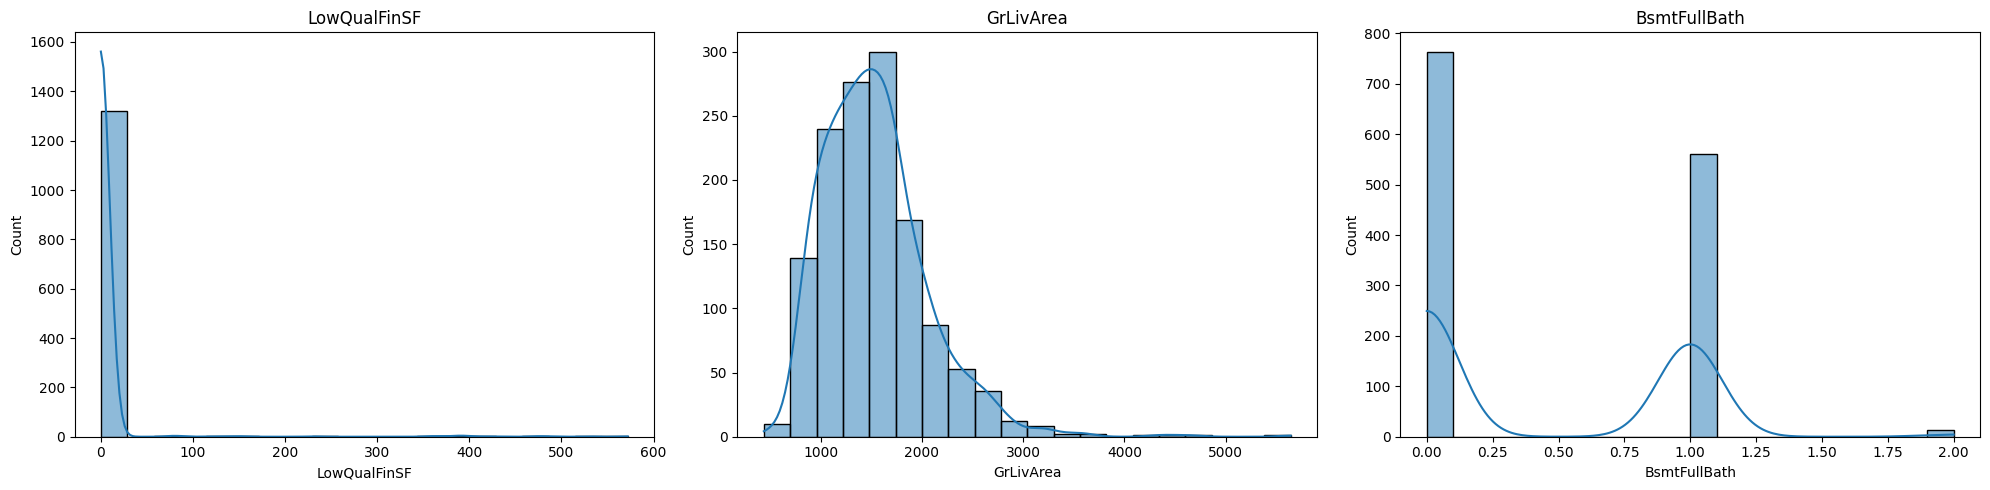

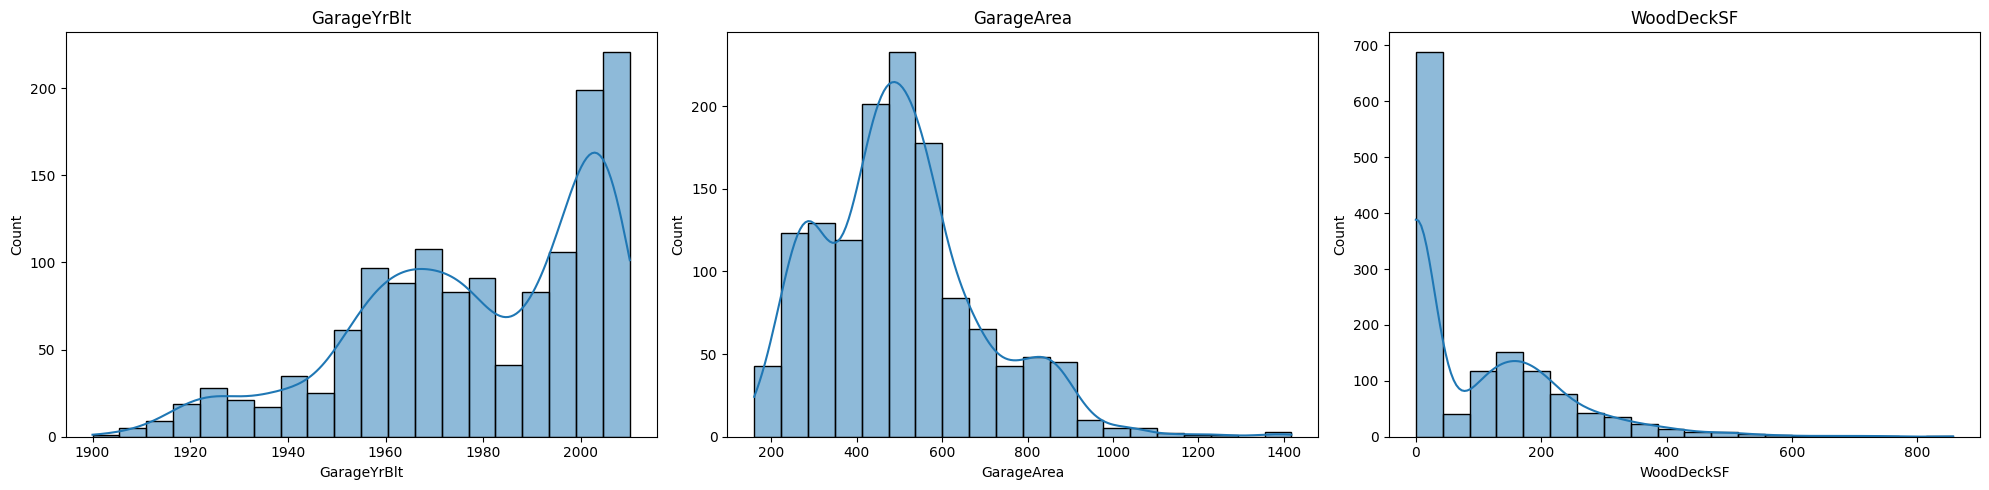

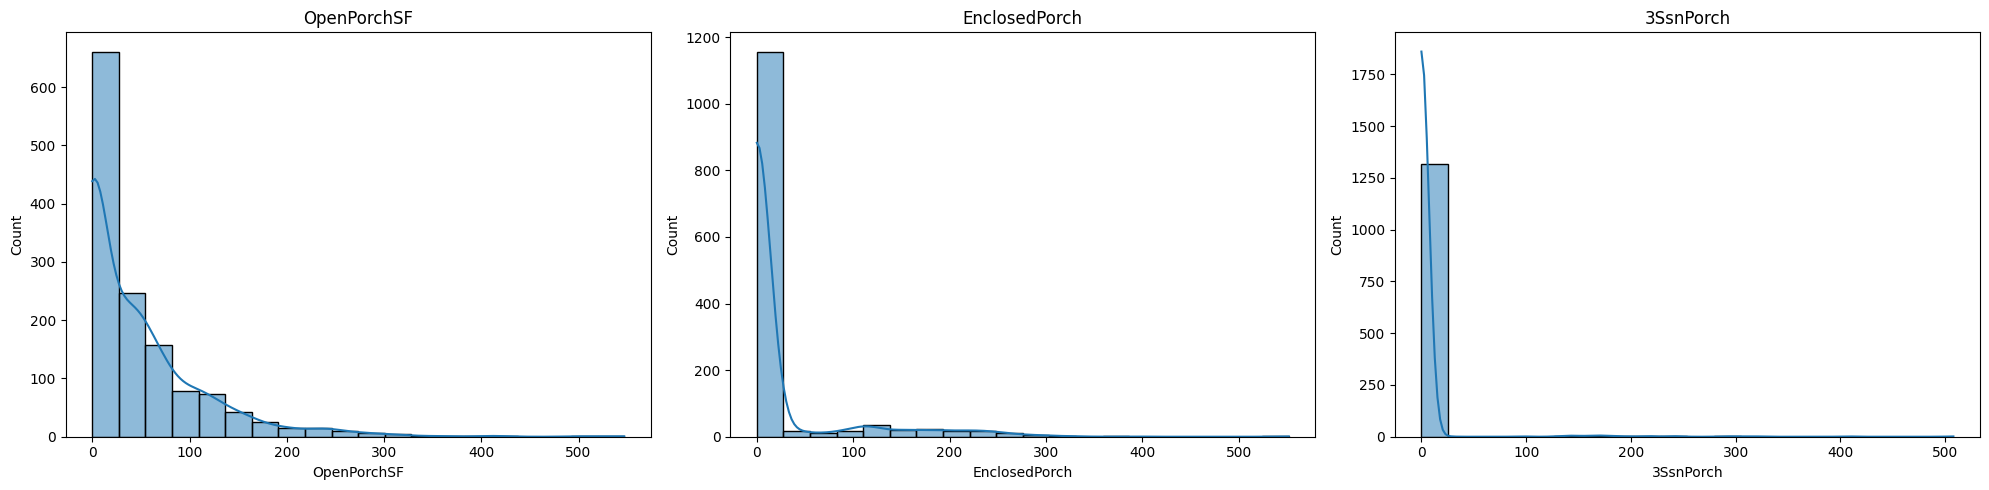

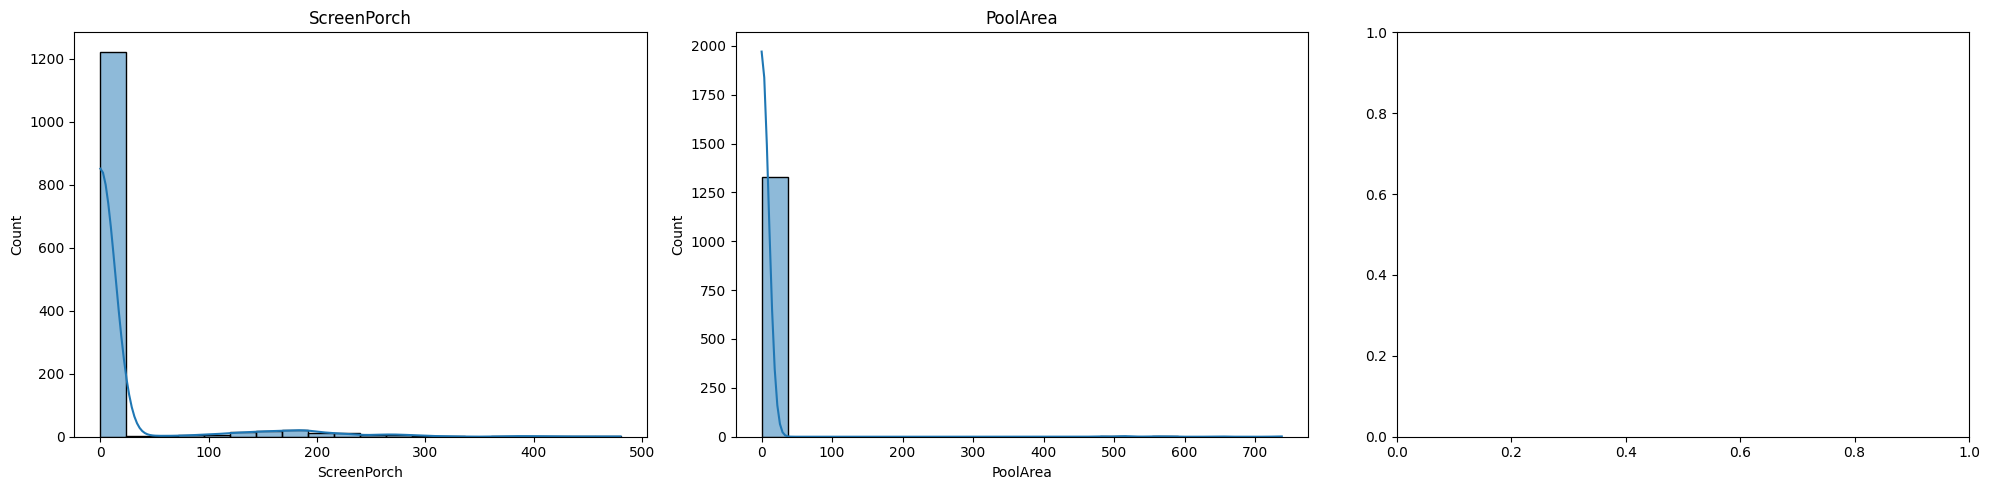

In [32]:
plt.rcParams["figure.figsize"] = [20, 5]
plt.rcParams["figure.autolayout"] = True
f = None
axes = None
for c in range(0,len(numeric_cols)):
    if(c%3 == 0):
        f, axes = plt.subplots(1, 3)
    sns.histplot(housing_cleaned[numeric_cols[c]], ax=axes[c%3], kde=True, bins=20).set(title=numeric_cols[c])
    if(c%3 == 2):
        plt.show()
plt.show()

#### Visual Summary

Most of the numeric columns are well distributed over the data. Some of them have two peaks as well and some of them are normally distributed. 

However a few columns have too much skewed data concentrated at 0 or nearby value. We will get the 90 perecentile values in each of them to see if these columns are mostly irrelvant for model building.

In [33]:
housing_cleaned[numeric_cols].quantile(0.90)

LotFrontage         93.0
LotArea          14575.9
MasVnrArea         340.0
BsmtFinSF1        1079.9
BsmtFinSF2         134.1
BsmtUnfSF         1242.7
TotalBsmtSF       1616.3
1stFlrSF          1686.3
2ndFlrSF           975.6
LowQualFinSF         0.0
GrLivArea         2175.3
BsmtFullBath         1.0
GarageYrBlt       2006.0
GarageArea         772.6
WoodDeckSF         264.3
OpenPorchSF        130.0
EnclosedPorch      109.2
3SsnPorch            0.0
ScreenPorch          0.0
PoolArea             0.0
Name: 0.9, dtype: float64

In [34]:
# following columns could be candidate for drop, 
# LowQualFinSF, BsmtFullBath, 3SsnPorch, ScreenPorch, PoolArea
# given their value distributions IQR seem ok

housing_cleaned[['LowQualFinSF', 'BsmtFullBath', '3SsnPorch', 'ScreenPorch', 'PoolArea']].describe()


,LowQualFinSF,BsmtFullBath,3SsnPorch,ScreenPorch,PoolArea
count,1338.000000,1338.000000,1338.000000,1338.00000,1338.000000
mean,4.221973,0.438714,3.585949,16.43423,3.010463
std,40.712916,0.515630,30.224622,58.05159,41.961337
min,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000
75%,0.000000,1.000000,0.000000,0.00000,0.000000
max,572.000000,2.000000,508.000000,480.00000,738.000000


In [35]:
# so it's confirmed, we can drop them .. they would not be significant in defining the change in target variable because for more than 90% of records, they have same value.
print(f"Before {housing_cleaned.shape}")
housing_cleaned.drop(columns=['LowQualFinSF', 'BsmtFullBath', '3SsnPorch', 'ScreenPorch', 'PoolArea'], inplace=True)
print(f"After {housing_cleaned.shape}")

Before (1338, 54)
After (1338, 49)


### Data Exploration Summary

In the above exercise we are able to reduce the unneeded columns and rows. First we will verify that the distribution and overall stats for SalePrice remain same as given in the "Analyze SalePrice" section.

Following table shows the reduction in columns and rows.

| | Old | New |
|--|--|--|
|Columns|81|48|
|Rows|1460|1338|

Now housing_cleaned is a fit dataset to apply furthersteps.

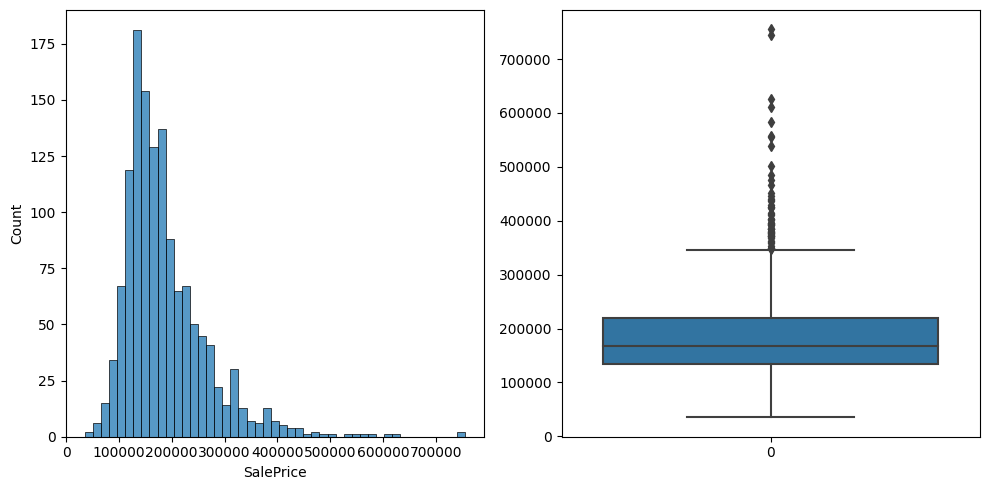

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [36]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 2)

sns.histplot(housing_cleaned["SalePrice"], ax=axes[0])
sns.boxplot(housing_cleaned["SalePrice"], ax=axes[1])
plt.show()
housing_cleaned["SalePrice"].describe()

In [37]:
housing_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 49 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1338 non-null   int64  
 1   MSZoning       1338 non-null   object 
 2   LotFrontage    1338 non-null   float64
 3   LotArea        1338 non-null   int64  
 4   LotShape       1338 non-null   object 
 5   Neighborhood   1338 non-null   object 
 6   HouseStyle     1338 non-null   object 
 7   OverallQual    1338 non-null   int64  
 8   OverallCond    1338 non-null   int64  
 9   YearBuilt      1338 non-null   int64  
 10  YearRemodAdd   1338 non-null   int64  
 11  RoofStyle      1338 non-null   object 
 12  Exterior1st    1338 non-null   object 
 13  Exterior2nd    1338 non-null   object 
 14  MasVnrType     1338 non-null   object 
 15  MasVnrArea     1338 non-null   float64
 16  ExterQual      1338 non-null   object 
 17  Foundation     1338 non-null   object 
 18  BsmtQual

## Data Transformation

In this section we will create new columns converting textual to numeric encoded data along with dummy columns for category columns. We will got step by step covering different sets of columns to tackle this exercise.

### Create straightforward columns

In [38]:
# create log of SalePrice column as target variable for our model as its distribution is more normal.

housing_cleaned["LogSalePrice"] = np.log(housing_cleaned["SalePrice"])

In [39]:
# create a boolean column if the house has been remodelled or not
housing_cleaned["Remodelled"]= [1 if r > 0 else 0 for r in  (housing_cleaned["YearRemodAdd"] - housing_cleaned["YearBuilt"])]

### Finalize Numeric Columns

In this section we will finalize which numeric predictor variables we want to keep for regression analysis.

In [40]:
real_numeric_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                'GrLivArea',  'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch']

housing_cleaned[real_numeric_cols+ ['LogSalePrice']].corr()


,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,LogSalePrice
LotFrontage,1.000000,0.301339,0.176253,0.221353,0.040545,0.102192,0.377885,0.410691,0.067602,0.362997,0.063654,0.332352,0.070598,0.144201,0.014729,0.335927
LotArea,0.301339,1.000000,0.096727,0.210148,0.110493,-0.014589,0.267188,0.288502,0.047773,0.255445,-0.025700,0.168630,0.167822,0.084942,-0.017968,0.250126
MasVnrArea,0.176253,0.096727,1.000000,0.253015,-0.083303,0.104662,0.365629,0.341001,0.169730,0.392006,0.249750,0.367237,0.149182,0.129015,-0.112225,0.423314
BsmtFinSF1,0.221353,0.210148,0.253015,1.000000,-0.064855,-0.552809,0.505000,0.450366,-0.151876,0.201974,0.144611,0.284095,0.187178,0.107561,-0.105669,0.342070
BsmtFinSF2,0.040545,0.110493,-0.083303,-0.064855,1.000000,-0.233449,0.083184,0.094065,-0.109254,-0.021993,-0.092595,-0.053411,0.061206,0.004211,0.045668,-0.020503
BsmtUnfSF,0.102192,-0.014589,0.104662,-0.552809,-0.233449,1.000000,0.363767,0.318097,-0.016117,0.222438,0.180539,0.195401,-0.020711,0.122171,-0.003372,0.194456
TotalBsmtSF,0.377885,0.267188,0.365629,0.505000,0.083184,0.363767,1.000000,0.893110,-0.234070,0.460778,0.321500,0.511475,0.214364,0.255939,-0.104484,0.589520
1stFlrSF,0.410691,0.288502,0.341001,0.450366,0.094065,0.318097,0.893110,1.000000,-0.220279,0.554846,0.237928,0.500071,0.233200,0.226615,-0.056003,0.599786
2ndFlrSF,0.067602,0.047773,0.169730,-0.151876,-0.109254,-0.016117,-0.234070,-0.220279,1.000000,0.685710,0.060414,0.124564,0.081291,0.202791,0.059654,0.308708
GrLivArea,0.362997,0.255445,0.392006,0.201974,-0.021993,0.222438,0.460778,0.554846,0.685710,1.000000,0.224903,0.477868,0.241277,0.341273,0.012779,0.704739


#### Summary

Except BsmtFinSF2, all other numerical predictors seem to have some correlation. Although some of them are having quite low correlation, we will consider them and let Ridge / Lasso derive the appropriate lambda for them.



In [41]:
# final_numeric_cols
final_numeric_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
                'GrLivArea',  'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF','EnclosedPorch']

### Transform and finalize Numeric Category Columns

In [42]:
# following columns are categorical but in numeric format.
num_category_cols = ['OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageCars', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'Remodelled']


#### Assign ordinal numbers to year columns 

We will subtract oldest year from all the year columns to get the relative year values.

In [43]:
min_year_build = housing_cleaned['YearBuilt'].min()
housing_cleaned['YearBuilt'] = housing_cleaned['YearBuilt']-min_year_build
housing_cleaned['YearRemodAdd'] = housing_cleaned['YearRemodAdd']-min_year_build
housing_cleaned['YrSold'] = housing_cleaned['YrSold']-min_year_build

In [44]:
housing_cleaned[['YearBuilt','YearRemodAdd','YrSold', 'MoSold','Remodelled','LogSalePrice']].corr()

,YearBuilt,YearRemodAdd,YrSold,MoSold,Remodelled,LogSalePrice
YearBuilt,1.000000,0.617156,-0.007898,0.004396,-0.395950,0.572592
YearRemodAdd,0.617156,1.000000,0.034503,0.014552,0.088670,0.565870
YrSold,-0.007898,0.034503,1.000000,-0.144862,0.020778,-0.028239
MoSold,0.004396,0.014552,-0.144862,1.000000,-0.008549,0.051261
Remodelled,-0.395950,0.088670,0.020778,-0.008549,1.000000,-0.040327
LogSalePrice,0.572592,0.565870,-0.028239,0.051261,-0.040327,1.000000


##### Summary

Only YearBuilt and YearRemodAdd seem to be correlated to the target variable rest are not at all correlated.

In [45]:
final_num_category_cols=['YearBuilt', 'YearRemodAdd']

#### Correlation of other numeric category variables

Lets find the correlation of remaining numeric category variables with LogSalePrice.

In [46]:
housing_cleaned[['OverallQual', 'OverallCond', 'GarageCars', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'LogSalePrice']].corr()

,OverallQual,OverallCond,GarageCars,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,LogSalePrice
OverallQual,1.000000,-0.163080,0.591878,0.580425,0.249283,0.081994,0.442941,0.377359,0.807486
OverallCond,-0.163080,1.000000,-0.249832,-0.211882,-0.073568,0.023180,-0.063883,-0.031910,-0.081275
GarageCars,0.591878,-0.249832,1.000000,0.512502,0.197136,0.119537,0.404416,0.245895,0.660141
FullBath,0.580425,-0.211882,0.512502,1.000000,0.134953,0.355542,0.547592,0.238053,0.612604
HalfBath,0.249283,-0.073568,0.197136,0.134953,1.000000,0.248138,0.357991,0.191549,0.286409
BedroomAbvGr,0.081994,0.023180,0.119537,0.355542,0.248138,1.000000,0.658923,0.117012,0.199379
TotRmsAbvGrd,0.442941,-0.063883,0.404416,0.547592,0.357991,0.658923,1.000000,0.332325,0.551437
Fireplaces,0.377359,-0.031910,0.245895,0.238053,0.191549,0.117012,0.332325,1.000000,0.470671
LogSalePrice,0.807486,-0.081275,0.660141,0.612604,0.286409,0.199379,0.551437,0.470671,1.000000


In [47]:
final_num_category_cols=['OverallQual', 'GarageCars', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'YearBuilt', 'YearRemodAdd']

### Convert Level based Category Columns 

There are following columns in dataset which contain values in some order like, quality being excellent to poor. We can assign the increasing numbers to these levels.

* LotShape
* ExterQual
* BsmtQual
* BsmtExposure
* BsmtFinType1
* HeatingQC
* KitchenQual
* GarageFinish

In [48]:
# convert LotShape to numeric. Since it's categorical but there is some order to the values like Regular lot is better than irregular ones, we can assign the ordinal based values instead of dummy variables.
housing_cleaned['LotShape'] = housing_cleaned['LotShape'].apply(lambda l : 4 if l == 'Reg' else 3 if l == 'IR1' else 2 if l == 'IR2' else 1)

In [49]:
# convert ExterQual to numeric, it is a categorical but has the order of being Excellent to Poor. So we can assign ordinal based values.

housing_cleaned['ExterQual'] = housing_cleaned['ExterQual'].apply(lambda l : 5 if l == 'Ex' else 4 if l == 'Gd' else 3 if l == 'TA' else 2 if l == 'Fa' else 1)

In [50]:
# convert BsmtQual to numeric, it is a categorical but has the order of being Excellent to Poor. So we can assign ordinal based values.

housing_cleaned['BsmtQual'] = housing_cleaned['BsmtQual'].apply(lambda l : 5 if l == 'Ex' else 4 if l == 'Gd' else 3 if l == 'TA' else 2 if l == 'Fa' else 1 if l == 'Po' else 0)

In [51]:
# convert BsmtExposure to numeric, it is a categorical but has the order of being Excellent to No Basement. So we can assign ordinal based values.

housing_cleaned['BsmtExposure'] = housing_cleaned['BsmtExposure'].apply(lambda l : 4 if l == 'Gd' else 3 if l == 'Av' else 2 if l == 'Mn' else 1 if l == 'No' else  0)

In [52]:
# convert BsmtFinType1 to numeric, it is a categorical but has the order of being Excellent to No Basement. So we can assign ordinal based values.

bft_map = { "GLQ":6, "ALQ":5, "BLQ":4, "Rec":3 , "LwQ":2, "Unf":1, "NA":1}
housing_cleaned['BsmtFinType1'].replace(bft_map, inplace=True)

In [53]:
# convert HeatingQC to numeric, it is a categorical but has the order of being Excellent to Poor. So we can assign ordinal based values.

qc_map = { "Ex":5, "Gd":4, "TA":3 , "Fa":2, "Po":1}
housing_cleaned['HeatingQC'].replace(qc_map, inplace=True)
housing_cleaned['KitchenQual'].replace(qc_map, inplace=True)

In [54]:
fin_map = { "Fin":3, "RFn":2, "Unf":1 , "NA":0}
housing_cleaned['GarageFinish'].replace(fin_map, inplace=True)

In [55]:
housing_cleaned[['LotShape','ExterQual','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','GarageFinish', 'LogSalePrice']].corr()

,LotShape,ExterQual,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,KitchenQual,GarageFinish,LogSalePrice
LotShape,1.000000,-0.179634,-0.225304,-0.175369,-0.093384,-0.111452,-0.156357,-0.230275,-0.287615
ExterQual,-0.179634,1.000000,0.645461,0.236749,0.192803,0.522331,0.711682,0.491138,0.674571
BsmtQual,-0.225304,0.645461,1.000000,0.322694,0.261377,0.425345,0.570835,0.541305,0.664109
BsmtExposure,-0.175369,0.236749,0.322694,1.000000,0.291637,0.133631,0.240722,0.247981,0.341862
BsmtFinType1,-0.093384,0.192803,0.261377,0.291637,1.000000,0.120050,0.209706,0.208913,0.287273
HeatingQC,-0.111452,0.522331,0.425345,0.133631,0.120050,1.000000,0.501530,0.384814,0.464982
KitchenQual,-0.156357,0.711682,0.570835,0.240722,0.209706,0.501530,1.000000,0.436173,0.662174
GarageFinish,-0.230275,0.491138,0.541305,0.247981,0.208913,0.384814,0.436173,1.000000,0.550217
LogSalePrice,-0.287615,0.674571,0.664109,0.341862,0.287273,0.464982,0.662174,0.550217,1.000000


#### Summary

All the columns are decently correlated to LogSalePrice, hence we will consider them all for our model.

In [56]:
final_ordinal_category_cols=['LotShape','ExterQual','BsmtQual','BsmtExposure','BsmtFinType1','HeatingQC','KitchenQual','GarageFinish']

### Generate Dummy variables and Analyze

We will generate the dummy variables for the following category columns, and analyze their correlation with LogSalePrice.
* Neighborhood
* HouseStyle
* RoofStyle
* Exterior1st
* Exterior2nd
* MasVnrType
* Foundation
* Heating
* GarageType
* SaleCondition
 
Please note that we will not drop first element in generating dummy to make sure that we are not missing any value while finding the correlation.


In [57]:
# Map numeric to textual for MSSubClass
msscls_map = {20:'1S1946NAS',
30:'1S1945OLD',
40:'1SFINAA',
45:'1.5SUNFAA',
50:'1.5SFINAA',
60:'2S1946N',
70:'2S1945OLD',
75:'2.5SAA',
80:'SPOML',
85:'SPFYR',
90:'DUPASAA',
120:'1SPUD1946N',
150:'1.5SPUDAA',
160:'2SPUD1946N',
180:'PUDMLSLV',
190:'2FAMASAA'}
housing_cleaned['MSSubClass'].replace(msscls_map, inplace=True)


In [58]:
dummy_tobe_cols = ['MSSubClass','MSZoning','Neighborhood',
 'HouseStyle',
 'RoofStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'GarageType',
 'SaleCondition',
 'SaleType']

In [59]:
# Generate dummy dataset
dummy_dataset = pd.get_dummies(housing_cleaned[dummy_tobe_cols])

In [60]:
dummy_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Columns: 123 entries, MSSubClass_1.5SFINAA to SaleType_WD
dtypes: uint8(123)
memory usage: 160.8 KB


#### Note

This process generated many dummy variables now lets analyze one by one how many of them are correlated to LogSalePrice. 

Following code block will take each category variable (in case of Exterior, we have merged because they are pointing to the same aspect of decor) and list only those dummy variables which have atleast 0.2 correlation in absolute terms (i.e. whether it is >= 0.2 or =< -0.2 )

In [61]:
cols_to_inspect_by_corr = ['MSSubClass','MSZoning','Neighborhood','Exterior','HouseStyle','RoofStyle','MasVnrType', 'Foundation','Heating','GarageType','SaleCondition','SaleType']
for col in cols_to_inspect_by_corr:
    cat_dummy_cols = [c for c in dummy_dataset.columns if c.startswith(col)]
    cat_dummy_sp = pd.concat([housing_cleaned["LogSalePrice"],dummy_dataset[cat_dummy_cols]], axis=1)
    cat_corr_ds = cat_dummy_sp.corr()
    print(f"### Correlation results for {col}")
    print(cat_corr_ds[abs(cat_corr_ds['LogSalePrice']) >= 0.2]['LogSalePrice'])
    print("")

### Correlation results for MSSubClass
LogSalePrice            1.000000
MSSubClass_1S1945OLD   -0.291915
MSSubClass_2S1946N      0.392347
Name: LogSalePrice, dtype: float64

### Correlation results for MSZoning
LogSalePrice    1.000000
MSZoning_RL     0.303286
MSZoning_RM    -0.352230
Name: LogSalePrice, dtype: float64

### Correlation results for Neighborhood
LogSalePrice            1.000000
Neighborhood_IDOTRR    -0.219335
Neighborhood_NoRidge    0.289088
Neighborhood_NridgHt    0.356443
Neighborhood_OldTown   -0.243202
Name: LogSalePrice, dtype: float64

### Correlation results for Exterior
LogSalePrice           1.000000
Exterior1st_MetalSd   -0.200173
Exterior1st_VinylSd    0.342761
Exterior2nd_VinylSd    0.344245
Name: LogSalePrice, dtype: float64

### Correlation results for HouseStyle
LogSalePrice         1.000000
HouseStyle_2Story    0.246825
Name: LogSalePrice, dtype: float64

### Correlation results for RoofStyle
LogSalePrice     1.000000
RoofStyle_Hip    0.202001
Name: LogS

In [62]:

final_dummy_cols_to_be_considered =  ['MSSubClass_1S1945OLD', 'MSSubClass_2S1946N', 'MSZoning_RL', 'MSZoning_RM', 'Neighborhood_IDOTRR','Neighborhood_NoRidge','Neighborhood_NridgHt','Neighborhood_OldTown','Exterior1st_MetalSd','Exterior1st_VinylSd','Exterior2nd_VinylSd','HouseStyle_2Story','RoofStyle_Hip','MasVnrType_BrkFace','MasVnrType_None','MasVnrType_Stone','Foundation_BrkTil','Foundation_CBlock','Foundation_PConc','GarageType_Attchd','GarageType_BuiltIn','GarageType_Detchd', 'SaleCondition_Partial', 'SaleType_New', 'SaleType_WD']


In [63]:
dummy_dataset[final_dummy_cols_to_be_considered].head()


,MSSubClass_1S1945OLD,MSSubClass_2S1946N,MSZoning_RL,MSZoning_RM,Neighborhood_IDOTRR,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Exterior1st_MetalSd,Exterior1st_VinylSd,...,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,SaleCondition_Partial,SaleType_New,SaleType_WD
0,0,1,1,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,1,0,0,0,0,1
2,0,1,1,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
4,0,1,1,0,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,1


## Model Building



### Model1

We will take only the visually filtered dummy variables in this model to make it succinct and hopefully faster. The total number of independent variables is 56 in this model.

In [64]:
X_m1_columns = final_numeric_cols+ final_num_category_cols + final_ordinal_category_cols + final_dummy_cols_to_be_considered  

m1_final_housing_dataset = pd.concat([housing_cleaned,dummy_dataset[final_dummy_cols_to_be_considered]],axis=1)[ X_m1_columns + ['LogSalePrice'] ]
m1_final_housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 57 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   LotFrontage            1338 non-null   float64
 1   LotArea                1338 non-null   int64  
 2   MasVnrArea             1338 non-null   float64
 3   BsmtFinSF1             1338 non-null   int64  
 4   BsmtUnfSF              1338 non-null   int64  
 5   TotalBsmtSF            1338 non-null   int64  
 6   1stFlrSF               1338 non-null   int64  
 7   2ndFlrSF               1338 non-null   int64  
 8   GrLivArea              1338 non-null   int64  
 9   GarageYrBlt            1338 non-null   float64
 10  GarageArea             1338 non-null   int64  
 11  WoodDeckSF             1338 non-null   int64  
 12  OpenPorchSF            1338 non-null   int64  
 13  EnclosedPorch          1338 non-null   int64  
 14  OverallQual            1338 non-null   int64  
 15  Gara

Let's scale the X set and split the train and test datasets.

In [65]:
# scaling the features - necessary before using Ridge or Lasso
from sklearn.preprocessing import scale

X_m1 = m1_final_housing_dataset[X_m1_columns]
X_m1 = pd.DataFrame(scale(X_m1))
X_m1.columns = X_m1_columns
X_m1.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       'OverallQual', 'GarageCars', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'YearBuilt', 'YearRemodAdd', 'LotShape',
       'ExterQual', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'HeatingQC',
       'KitchenQual', 'GarageFinish', 'MSSubClass_1S1945OLD',
       'MSSubClass_2S1946N', 'MSZoning_RL', 'MSZoning_RM',
       'Neighborhood_IDOTRR', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Exterior1st_MetalSd', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'HouseStyle_2Story', 'RoofStyle_Hip',
       'MasVnrType_BrkFace', 'MasVnrType_None', 'MasVnrType_Stone',
       'Foundation_BrkTil', 'Foundation_CBlock', 'Foundation_PConc',
       'GarageType_Attchd', 'GarageType_BuiltIn', 'GarageType_Detchd',
  

In [66]:
X_m1.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,...,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,SaleCondition_Partial,SaleType_New,SaleType_WD
0,-0.259379,-0.218363,0.461582,0.527157,-0.983421,-0.591875,-0.828516,1.128813,0.331321,0.985427,...,-0.325246,-0.326649,-0.874741,1.076134,0.755263,-0.260456,-0.617094,-0.313882,-0.309553,0.394259
1,0.417772,-0.107067,-0.594820,1.120240,-0.678727,0.409598,0.221935,-0.811389,-0.529579,-0.104844,...,-0.325246,-0.326649,1.143196,-0.929252,0.755263,-0.260456,-0.617094,-0.313882,-0.309553,0.394259
2,-0.123949,0.052620,0.278328,0.047458,-0.337652,-0.434007,-0.662928,1.156076,0.477367,0.904666,...,-0.325246,-0.326649,-0.874741,1.076134,0.755263,-0.260456,-0.617094,-0.313882,-0.309553,0.394259
3,-0.485096,-0.111906,-0.594820,-0.541263,-0.096626,-0.838543,-0.556848,0.906167,0.344773,0.783525,...,-0.325246,3.061387,-0.874741,-0.929252,-1.324042,-0.260456,1.620499,-0.313882,-0.309553,0.394259
4,0.598346,0.343926,1.291612,0.415954,-0.210318,0.120996,-0.080781,1.580921,1.269088,0.864286,...,-0.325246,-0.326649,-0.874741,1.076134,0.755263,-0.260456,-0.617094,-0.313882,-0.309553,0.394259


In [67]:
y_m1 = m1_final_housing_dataset['LogSalePrice']

In [68]:
from sklearn.model_selection import train_test_split
X_m1_train, X_m1_test, y_m1_train, y_m1_test = train_test_split(X_m1, y_m1, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

#### Linear Regression

In [69]:
lm = LinearRegression()
lm.fit(X_m1_train, y_m1_train)

LinearRegression()

In [70]:
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

12.063402037620515
[ 0.01565209  0.02726186  0.00342304  0.00630216 -0.02422751  0.04222529
 -0.00223475 -0.00854468  0.08522156 -0.02339464  0.04249577  0.00709133
  0.00560653  0.00727375  0.08955202  0.00284469  0.00395132  0.00834948
  0.00664723  0.01763574  0.02985121 -0.00262704  0.04085926 -0.01378339
  0.00863606  0.01453818  0.00999836  0.01230397  0.02057187  0.0231554
  0.00544328 -0.01407694 -0.00079916  0.00644443 -0.00755625 -0.01781614
  0.01143528  0.013968   -0.02318268  0.01369786 -0.00314246  0.01474913
 -0.00237167 -0.00160002  0.03479508  0.04052566  0.02207248  0.00577409
  0.01539322  0.02508093  0.05166286  0.02193049  0.04095993  0.03379363
 -0.01792483  0.00352778]


##### Residual Analysis

In [71]:
from sklearn.metrics import r2_score, mean_squared_error
y_m1_pred_train = lm.predict(X_m1_train)
y_m1_pred_test = lm.predict(X_m1_test)

metric = []
r2_train_lr = r2_score(y_m1_train, y_m1_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_m1_test, y_m1_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m1_train - y_m1_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m1_test - y_m1_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m1_train, y_m1_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m1_test, y_m1_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.8841684373999059
0.7648563793618789
14.805443769334367
14.534845134282932
0.01581778180484441
0.036156331179808286


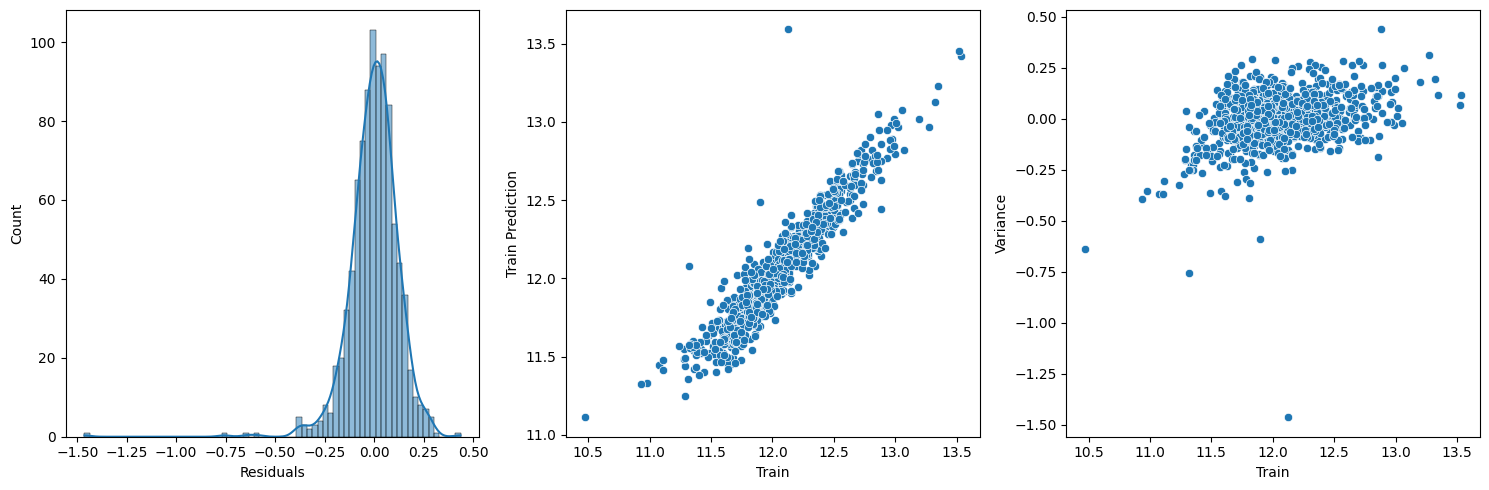

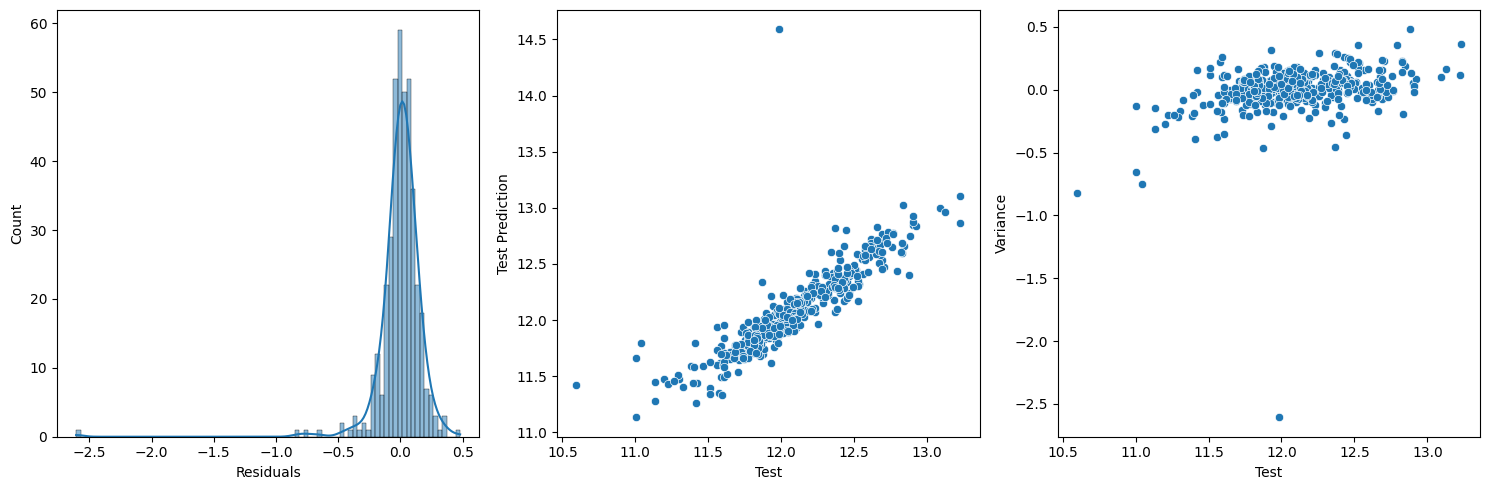

In [72]:
res = y_m1_train - y_m1_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_train, y=y_m1_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m1_train, y=(y_m1_train-y_m1_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m1_test - y_m1_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_test, y=y_m1_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m1_test, y=(y_m1_test-y_m1_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Ridge Regression

In [73]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_m1_train, y_m1_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [74]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [75]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_m1_train, y_m1_train)
print(ridge.coef_)

[ 0.01532062  0.02145346  0.00584445  0.01930822 -0.00928599  0.02877979
  0.02878285  0.02233284  0.04221171 -0.01208638  0.03145602  0.00817503
  0.00755201  0.0069289   0.07248511  0.0098457   0.00726373  0.00969298
  0.00670945  0.01961367  0.03065969 -0.00202256  0.03269785 -0.01317566
  0.01512559  0.01597663  0.01095383  0.0126757   0.01878546  0.02600737
  0.00683386 -0.01464953  0.00010025  0.00852458 -0.00942276 -0.01430159
  0.01143759  0.01345443 -0.01717591  0.01185834  0.00272876  0.00674471
  0.00041993  0.00012931  0.00440737  0.00957497  0.00434414 -0.00099622
 -0.00244872  0.00781484  0.01960804  0.00530214  0.00985129  0.01004778
  0.00410848  0.00223775]


##### Residual Analysis

In [76]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_m1_pred_train = ridge.predict(X_m1_train)
y_m1_pred_test = ridge.predict(X_m1_test)

metric2 = []
r2_train_lr = r2_score(y_m1_train, y_m1_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_m1_test, y_m1_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m1_train - y_m1_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m1_test - y_m1_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m1_train, y_m1_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m1_test, y_m1_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.8808953549868707
0.7754219439361587
15.223805021922285
13.88175982230774
0.016264748955045177
0.03453174085151179


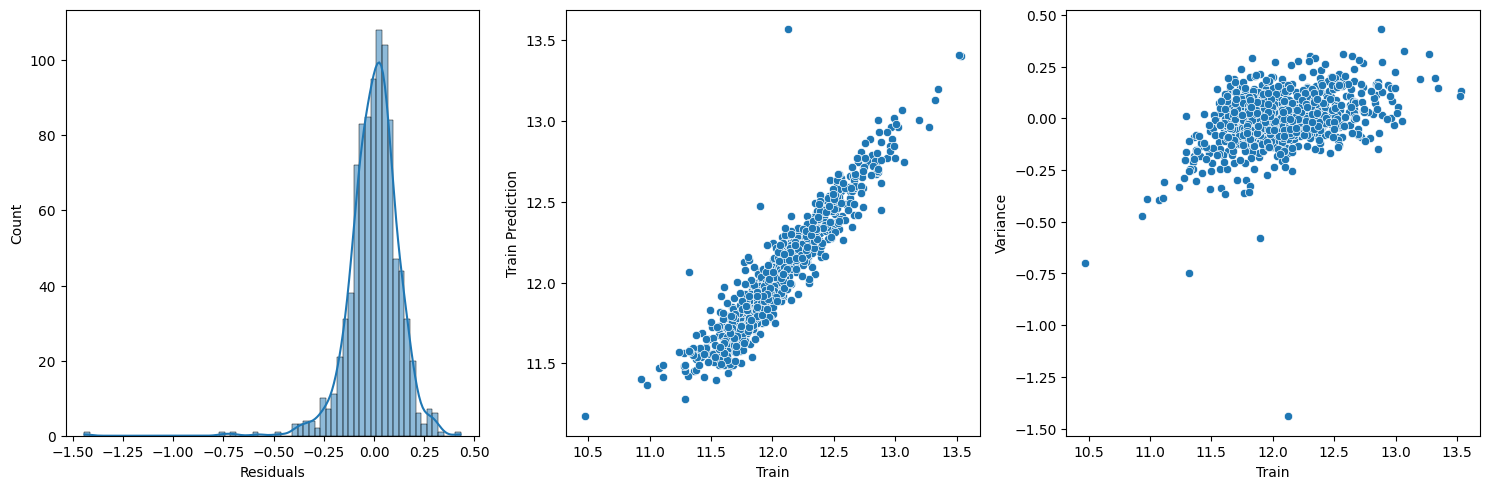

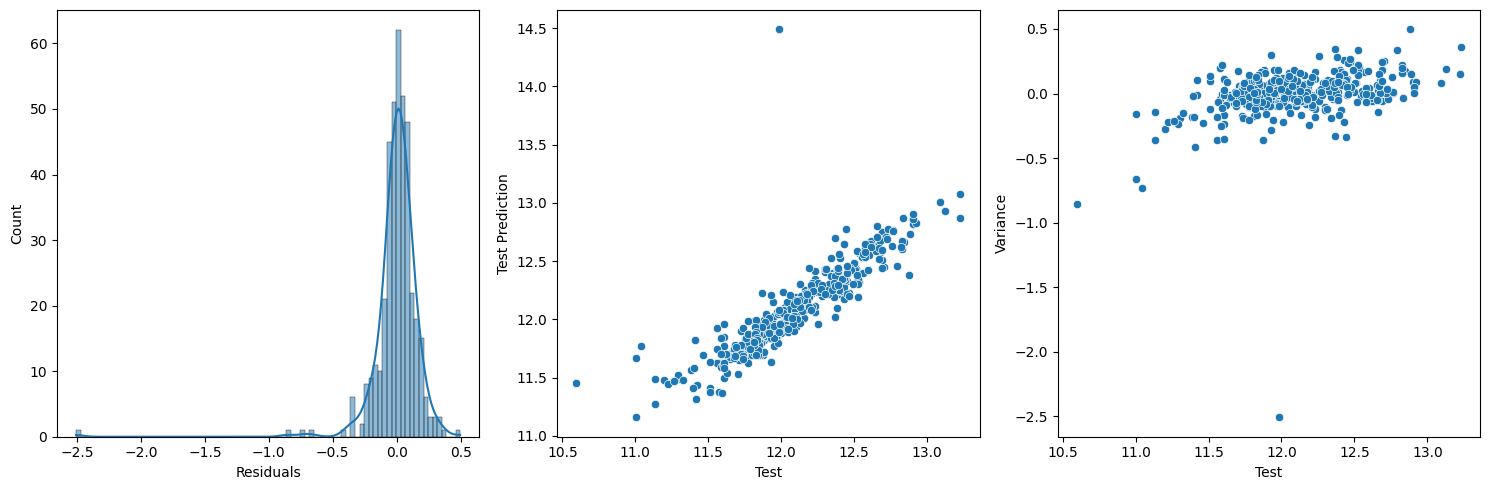

In [77]:
res = y_m1_train - y_m1_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_train, y=y_m1_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m1_train, y=(y_m1_train-y_m1_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m1_test - y_m1_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_test, y=y_m1_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m1_test, y=(y_m1_test-y_m1_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Lasso Regression

In [78]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_m1_train, y_m1_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [79]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [80]:
alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_m1_train, y_m1_train) 

Lasso(alpha=0.001)

In [81]:
lasso.coef_

array([ 0.01536332,  0.02381586,  0.00046726,  0.0156214 , -0.01395079,
        0.03847897,  0.        ,  0.        ,  0.08119266, -0.01546688,
        0.04031272,  0.00670681,  0.00448296,  0.00586949,  0.09023986,
        0.00228769,  0.00090127,  0.00584453,  0.00587742,  0.01667937,
        0.03024916,  0.        ,  0.03884703, -0.01308086,  0.00816721,
        0.01354581,  0.00961568,  0.01220486,  0.01965916,  0.02429267,
        0.00496638, -0.01337895, -0.        ,  0.00816116, -0.0073042 ,
       -0.01583451,  0.01006046,  0.01282538, -0.02023962,  0.01247624,
        0.        ,  0.00930683, -0.        , -0.        ,  0.        ,
        0.00223233,  0.        , -0.00059989,  0.        ,  0.00839336,
        0.02903525,  0.00941902,  0.0186853 ,  0.01232832,  0.        ,
        0.        ])

##### Residual Analysis

In [82]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_m1_pred_train = lasso.predict(X_m1_train)
y_m1_pred_test = lasso.predict(X_m1_test)

metric3 = []
r2_train_lr = r2_score(y_m1_train, y_m1_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_m1_test, y_m1_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m1_train - y_m1_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m1_test - y_m1_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m1_train, y_m1_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m1_test, y_m1_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.8826796954041278
0.7671908809378312
14.995732887522628
14.390543456950056
0.01602108214478913
0.03579737178345785


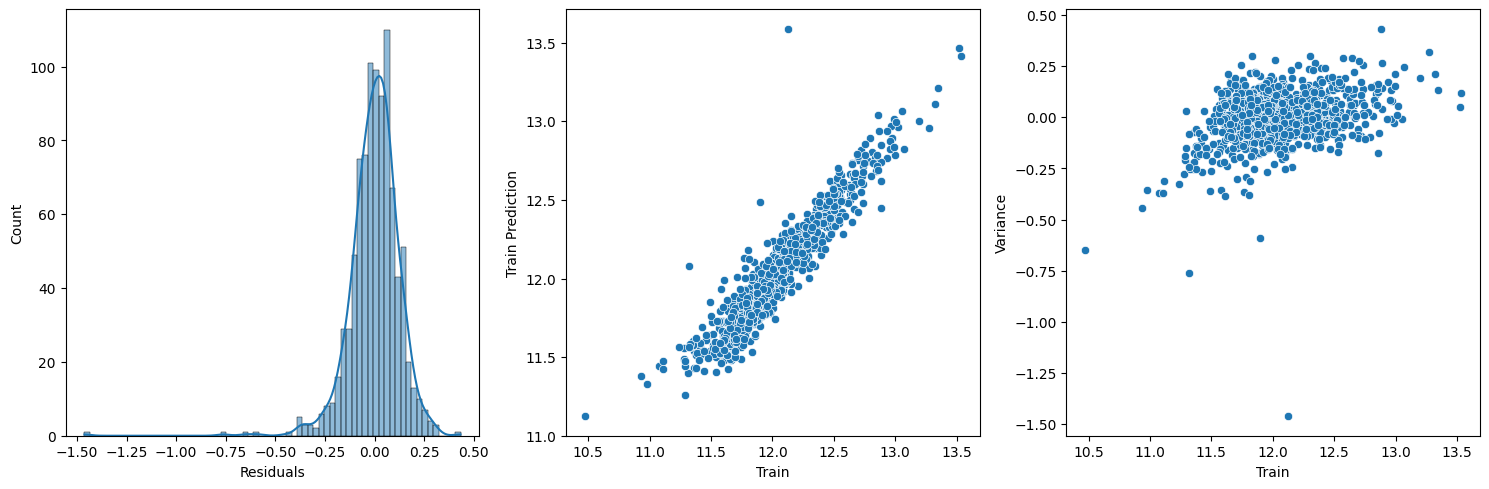

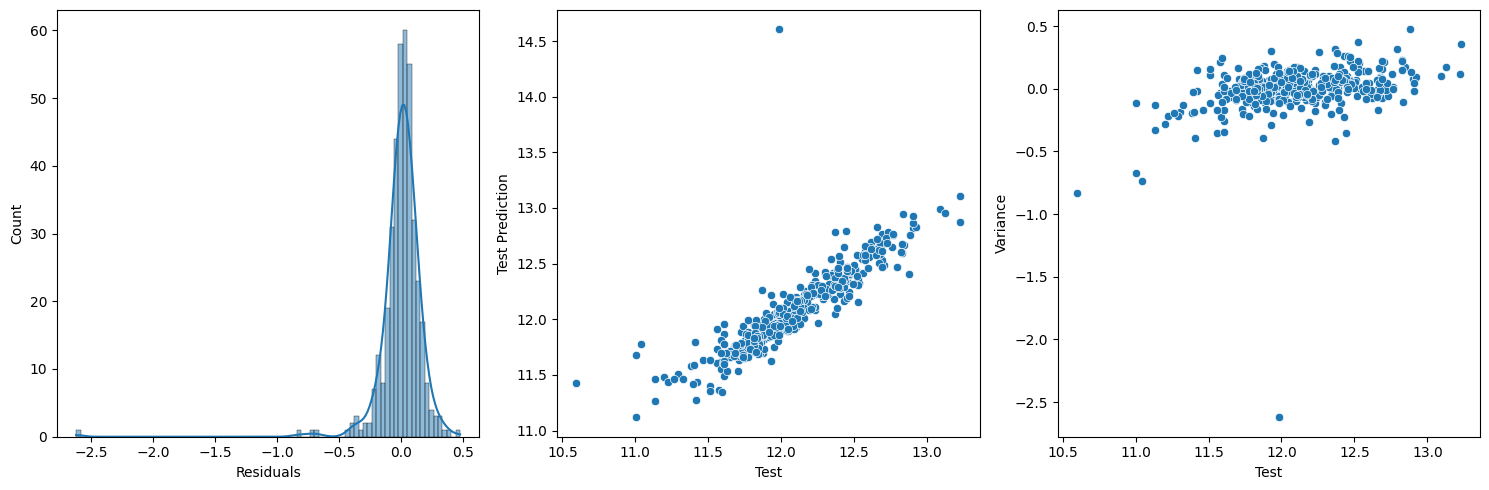

In [83]:
res = y_m1_train - y_m1_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_train, y=y_m1_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m1_train, y=(y_m1_train-y_m1_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m1_test - y_m1_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m1_test, y=y_m1_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m1_test, y=(y_m1_test-y_m1_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Summary Statistics

In [84]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.884168,0.880895,0.882680
1,R2 Score (Test),0.764856,0.775422,0.767191
2,RSS (Train),14.805444,15.223805,14.995733
3,RSS (Test),14.534845,13.881760,14.390543
4,MSE (Train),0.125769,0.127533,0.126574
5,MSE (Test),0.190148,0.185827,0.189202


In [85]:
betas = pd.DataFrame(index=X_m1.columns)
betas.rows = X_m1.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,0.015652,0.015321,0.015363
LotArea,0.027262,0.021453,0.023816
MasVnrArea,0.003423,0.005844,0.000467
BsmtFinSF1,0.006302,0.019308,0.015621
BsmtUnfSF,-0.024228,-0.009286,-0.013951
TotalBsmtSF,0.042225,0.028780,0.038479
1stFlrSF,-0.002235,0.028783,0.000000
2ndFlrSF,-0.008545,0.022333,0.000000
GrLivArea,0.085222,0.042212,0.081193
GarageYrBlt,-0.023395,-0.012086,-0.015467


In [86]:
# Find the variables which lasso marked as insignificant
betas[betas['Lasso'] != 0].shape

(44, 3)

#### Summary

Model 1 is performing well based on R2 score for all three regression techniques. The R2 score on train data is at ~0.88 and on test data ~0.77.

The other parameters like Residual sum of square, and mean square error are within the permissible range and almost same for all the three techniques. This suggests that we have made appropriate feature selection in our model (using EDA and Transformation)

Lasso could reduce the variables to **44** from **56** by deriving their hyperparameter to 0.

Also the errors are normally distributed and model is homoscedastic for all the regression algorithms.

### Model 2

We will take all the dummy variables in this model to see whether it provides better accuracy and also to check wither Lasso is able to reduce the variables by finding zero coeffecient for some of them.

In [87]:
final_dummy_cols_to_be_considered = np.array(dummy_dataset.columns[:]).tolist()

X_m2_columns = final_numeric_cols+ final_num_category_cols + final_ordinal_category_cols + final_dummy_cols_to_be_considered  

m2_final_housing_dataset = pd.concat([housing_cleaned,dummy_dataset[final_dummy_cols_to_be_considered]],axis=1)[ X_m2_columns + ['LogSalePrice'] ]
m2_final_housing_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Columns: 155 entries, LotFrontage to LogSalePrice
dtypes: float64(4), int64(28), uint8(123)
memory usage: 495.3 KB


In this model the dataset has **154** columns, where is quite a high number.

In [88]:
# scaling the features - necessary before using Ridge or Lasso

X_m2 = m2_final_housing_dataset[X_m2_columns]
X_m2 = pd.DataFrame(scale(X_m2))
X_m2.columns = X_m2_columns
X_m2.columns

Index(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt',
       ...
       'SaleCondition_Partial', 'SaleType_COD', 'SaleType_CWD', 'SaleType_Con',
       'SaleType_ConLD', 'SaleType_ConLI', 'SaleType_ConLw', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'],
      dtype='object', length=154)

In [89]:
X_m2.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageYrBlt,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,-0.259379,-0.218363,0.461582,0.527157,-0.983421,-0.591875,-0.828516,1.128813,0.331321,0.985427,...,-0.313882,-0.180021,-0.054759,-0.038691,-0.067116,-0.054759,-0.054759,-0.309553,-0.027349,0.394259
1,0.417772,-0.107067,-0.594820,1.120240,-0.678727,0.409598,0.221935,-0.811389,-0.529579,-0.104844,...,-0.313882,-0.180021,-0.054759,-0.038691,-0.067116,-0.054759,-0.054759,-0.309553,-0.027349,0.394259
2,-0.123949,0.052620,0.278328,0.047458,-0.337652,-0.434007,-0.662928,1.156076,0.477367,0.904666,...,-0.313882,-0.180021,-0.054759,-0.038691,-0.067116,-0.054759,-0.054759,-0.309553,-0.027349,0.394259
3,-0.485096,-0.111906,-0.594820,-0.541263,-0.096626,-0.838543,-0.556848,0.906167,0.344773,0.783525,...,-0.313882,-0.180021,-0.054759,-0.038691,-0.067116,-0.054759,-0.054759,-0.309553,-0.027349,0.394259
4,0.598346,0.343926,1.291612,0.415954,-0.210318,0.120996,-0.080781,1.580921,1.269088,0.864286,...,-0.313882,-0.180021,-0.054759,-0.038691,-0.067116,-0.054759,-0.054759,-0.309553,-0.027349,0.394259


In [90]:
y_m2 = m2_final_housing_dataset['LogSalePrice']

In [91]:

X_m2_train, X_m2_test, y_m2_train, y_m2_test = train_test_split(X_m2, y_m2, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

#### Linear Regression

In [92]:
lm = LinearRegression()
lm.fit(X_m2_train, y_m2_train)
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

-5510591.114569106
[ 8.62898170e-03  2.06541407e-02  3.07107389e-04  1.32921803e-02
 -1.87369310e-02  4.61462650e-02 -3.80684519e-02 -1.98040528e-02
  1.14023764e-01 -1.61160094e-02  3.74872003e-02  1.10101328e-02
  2.39081135e-03  5.66614947e-03  6.66301161e-02  6.51140844e-03
  7.15307154e-03  1.27956722e-02  2.70393512e-03  2.64923220e-02
  2.11020098e-02  2.09417881e-02  2.91549121e-02 -1.06298386e-02
 -4.40601004e-03  1.45282697e-02  1.23957267e-02  1.10473417e-02
  1.83129983e-02  2.42843220e-02  3.42824399e-03 -5.92886981e+09
 -1.64190359e+09 -3.84625674e+09 -9.72565603e+09 -1.09665953e+09
 -4.92623696e+09 -2.04395777e+09 -2.49670047e+09 -4.05672811e+09
 -8.31740450e+09 -4.19009891e+09 -2.87526959e+09 -1.34212092e+09
 -2.37663838e+09 -4.05672811e+09  5.05824542e+09  1.37927309e+10
  5.92462527e+09  2.64053627e+10  2.29523668e+10  4.39247057e+09
  1.51513461e+09  4.12912987e+09  7.22013040e+09  5.41360522e+09
  1.22277780e+10  7.43833827e+09  8.73256119e+09  9.13347190e+09
  5.71

##### Residual Analysis

In [93]:
y_m2_pred_train = lm.predict(X_m2_train)
y_m2_pred_test = lm.predict(X_m2_test)

metric = []
r2_train_lr = r2_score(y_m2_train, y_m2_pred_train)
print(r2_train_lr)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_m2_test, y_m2_pred_test)
print(r2_test_lr)
metric.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m2_train - y_m2_pred_train))
print(rss1_lr)
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m2_test - y_m2_pred_test))
print(rss2_lr)
metric.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m2_train, y_m2_pred_train)
print(mse_train_lr)
metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m2_test, y_m2_pred_test)
print(mse_test_lr)
metric.append(mse_test_lr**0.5)

0.9172987200923031
-8.890446833202571e+19
10.570772955491456
5.495418822951744e+21
0.011293560849884034
1.3670196076994386e+19


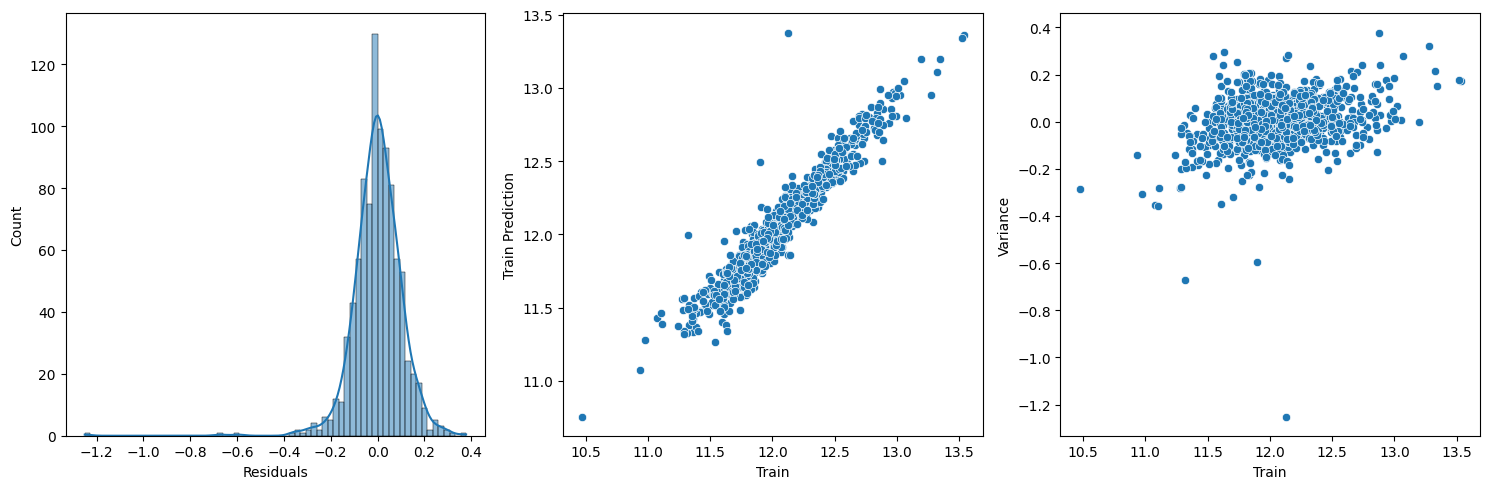

Can not plot residual for test data. Reason : Unable to allocate 20.8 TiB for an array with shape (2865305922300,) and data type float64


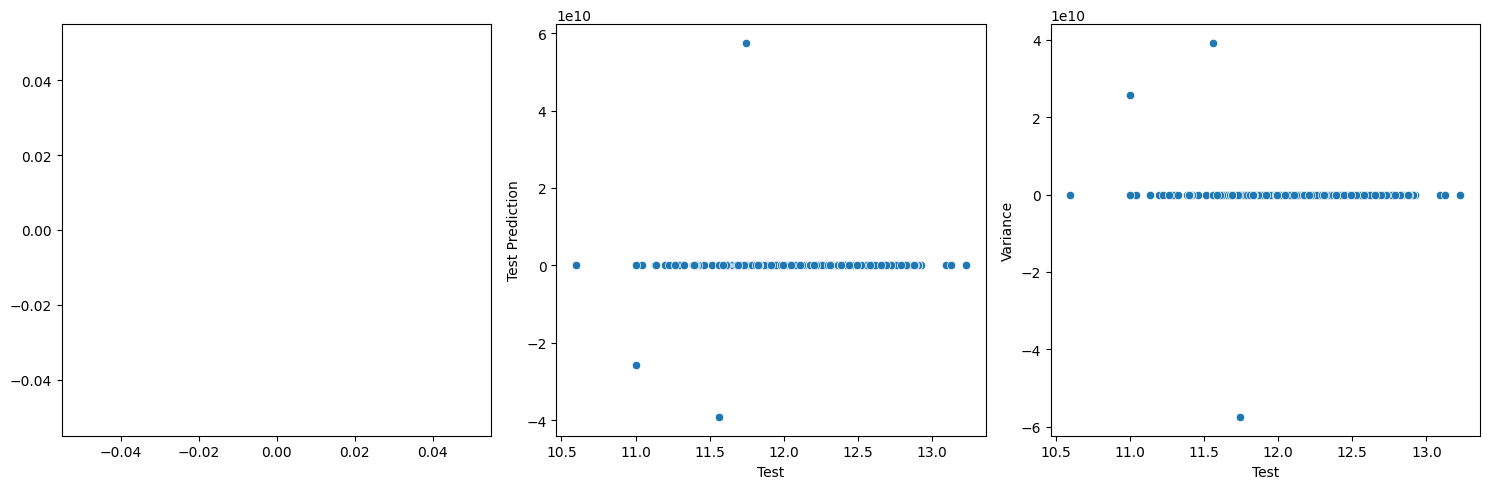

In [94]:
res = y_m2_train - y_m2_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m2_train, y=y_m2_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m2_train, y=(y_m2_train-y_m2_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m2_test - y_m2_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)
try:
    sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
except Exception as e:
    print(f"Can not plot residual for test data. Reason : {e}")    

sns.scatterplot(x=y_m2_test, y=y_m2_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m2_test, y=(y_m2_test-y_m2_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Linear Regression - Summary

It is interesting to see that the R2 score on train data is 0.91 which is a very good score however R2 score for test data is complete garbage and hence it is a clear case of overfitting which is probably happening due to large number of variables and many of them might not be significant.

Rerefence : [https://stackoverflow.com/questions/67959140/what-does-negative-r2-score-mean-in-regression](https://stackoverflow.com/questions/67959140/what-does-negative-r2-score-mean-in-regression)

The residual histogram for test data can not be rendered because the residuals are almost 0 and very close to each other. This is a known problem in seaborn library. Ref : [https://github.com/mwaskom/seaborn/issues/2325#issuecomment-712249812](https://github.com/mwaskom/seaborn/issues/2325#issuecomment-712249812)

This is a clear case of overfitting and would require regularization.

Now lets see how Ridge and Lasso deals with this dataset.

#### Ridge Regression 

In [95]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_m2_train, y_m2_train) 
#https://scikit-learn.org/stable/modules/model_evaluation.html

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [96]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 100}


In [97]:
#Fitting Ridge model for alpha = 10 and printing coefficients which have been penalised
alpha = 100
ridge = Ridge(alpha=alpha)

ridge.fit(X_m2_train, y_m2_train)
print(ridge.coef_)

[ 1.06327188e-02  1.83706958e-02  5.49263678e-03  2.13064480e-02
 -8.59049519e-03  2.72328420e-02  2.61641232e-02  2.20528533e-02
  3.89167163e-02 -6.19155838e-03  2.88883742e-02  1.06534755e-02
  4.66404493e-03  4.38770055e-03  5.48005915e-02  1.34899144e-02
  1.00651667e-02  1.28226424e-02  4.68481275e-03  2.41414261e-02
  2.19438418e-02  1.18371001e-02  2.42296563e-02 -1.07405384e-02
  6.31026425e-03  1.63072132e-02  1.38760159e-02  1.20100908e-02
  1.66686711e-02  2.41531997e-02  5.38681058e-03  7.34031189e-04
  5.99827568e-04 -1.64406794e-02  1.42146090e-02 -4.53745634e-03
 -5.36793877e-03  9.00388715e-03 -5.83165822e-03  7.70850615e-03
  3.24639098e-03 -1.51584286e-02 -7.12478352e-03 -2.20003404e-03
 -3.63855895e-03 -3.80692448e-03 -2.54721488e-02  8.72787084e-03
 -8.00624913e-03  6.78316161e-03 -5.36827476e-03 -2.05102465e-03
 -2.10083934e-03 -4.68321483e-03  1.09581478e-02  8.92692640e-03
 -4.16615917e-03  2.39810168e-02 -1.92054919e-02 -5.52488566e-03
 -5.06834376e-03 -1.64405

##### Residual Analysis

In [98]:
# Lets calculate some metrics such as R2 score, RSS and RMSE
y_m2_pred_train = ridge.predict(X_m2_train)
y_m2_pred_test = ridge.predict(X_m2_test)

metric2 = []
r2_train_lr = r2_score(y_m2_train, y_m2_pred_train)
print(r2_train_lr)
metric2.append(r2_train_lr)

r2_test_lr = r2_score(y_m2_test, y_m2_pred_test)
print(r2_test_lr)
metric2.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m2_train - y_m2_pred_train))
print(rss1_lr)
metric2.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m2_test - y_m2_pred_test))
print(rss2_lr)
metric2.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m2_train, y_m2_pred_train)
print(mse_train_lr)
metric2.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m2_test, y_m2_pred_test)
print(mse_test_lr)
metric2.append(mse_test_lr**0.5)

0.9149287027656494
0.8079572414322127
10.873705571390479
11.870667583361827
0.01161720680704111
0.029529023839208527


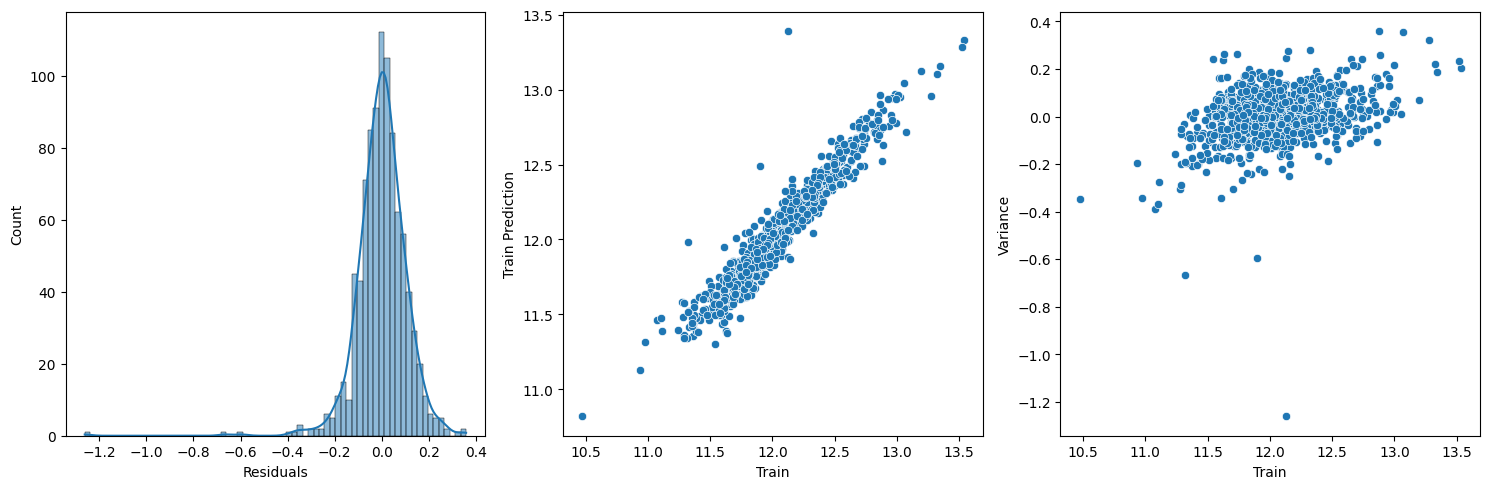

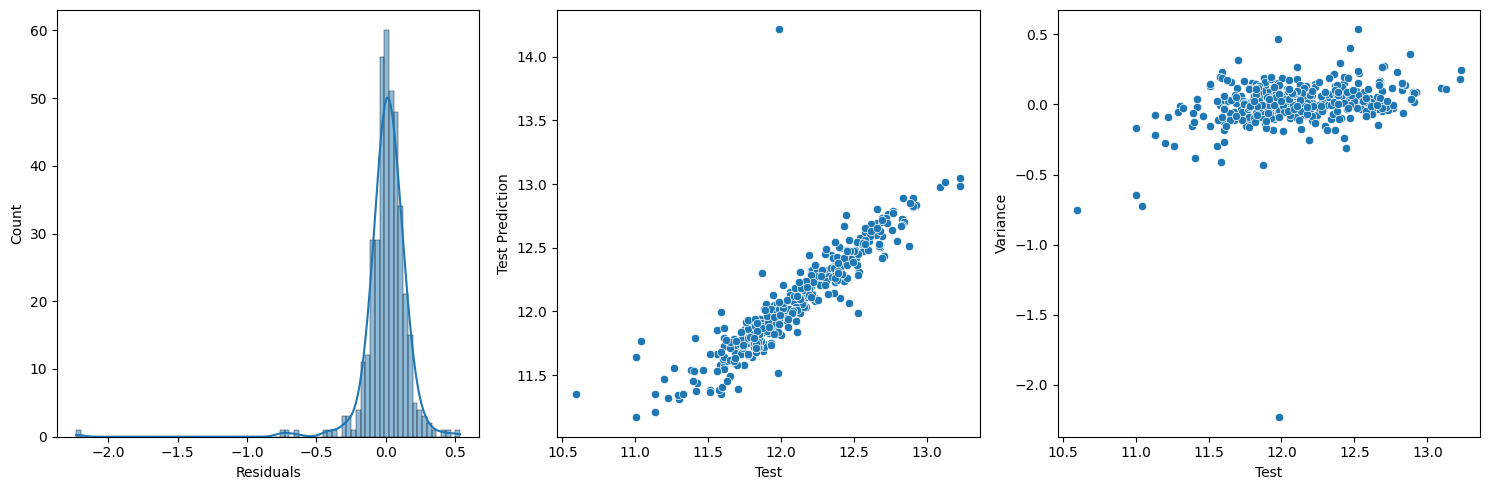

In [99]:
res = y_m2_train - y_m2_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m2_train, y=y_m2_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m2_train, y=(y_m2_train-y_m2_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m2_test - y_m2_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m2_test, y=y_m2_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m2_test, y=(y_m2_test-y_m2_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Ridge Regression - Summary

Ridge is able to build decent model which works well on train data with R2 score of 0.91 and on test data with R2 score of 0.80. So it is able to tune the hyperparameters and regularize the model to not get overfit on train data.

#### Lasso Regression

In [100]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_m2_train, y_m2_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [101]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.001}


In [102]:
#Fitting Ridge model for alpha = 100 and printing coefficients which have been penalised

alpha = 0.001

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_m2_train, y_m2_train) 

Lasso(alpha=0.001)

In [103]:
lasso.coef_

array([ 9.80270210e-03,  2.06171779e-02,  6.32089318e-04,  1.91495230e-02,
       -1.19653636e-02,  3.16430009e-02,  0.00000000e+00,  9.32911406e-03,
        7.91163541e-02, -7.69486492e-03,  3.51091794e-02,  8.88673202e-03,
        2.91187290e-03,  2.83323639e-03,  6.92371066e-02,  7.19041451e-03,
        4.80959924e-03,  1.06184443e-02,  1.69800092e-03,  2.32472475e-02,
        2.07822033e-02,  2.01982563e-02,  2.81584088e-02, -9.74098235e-03,
        0.00000000e+00,  1.37512083e-02,  1.46364479e-02,  1.12816184e-02,
        1.74867695e-02,  2.34834474e-02,  2.95502166e-03, -0.00000000e+00,
       -0.00000000e+00, -1.48228816e-02,  2.13729477e-02, -3.63062285e-03,
       -2.36744964e-03,  4.75249993e-03, -3.94944578e-03,  4.27466689e-03,
        0.00000000e+00, -1.67450862e-02, -5.92104103e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -3.16950969e-02,  5.76156312e-03,
       -8.66469729e-03,  0.00000000e+00, -1.04873389e-02, -0.00000000e+00,
       -3.00975477e-04, -

##### Residual Analysis

In [104]:
# Lets calculate some metrics such as R2 score, RSS and RMSE

y_m2_pred_train = lasso.predict(X_m2_train)
y_m2_pred_test = lasso.predict(X_m2_test)

metric3 = []
r2_train_lr = r2_score(y_m2_train, y_m2_pred_train)
print(r2_train_lr)
metric3.append(r2_train_lr)

r2_test_lr = r2_score(y_m2_test, y_m2_pred_test)
print(r2_test_lr)
metric3.append(r2_test_lr)

rss1_lr = np.sum(np.square(y_m2_train - y_m2_pred_train))
print(rss1_lr)
metric3.append(rss1_lr)

rss2_lr = np.sum(np.square(y_m2_test - y_m2_pred_test))
print(rss2_lr)
metric3.append(rss2_lr)

mse_train_lr = mean_squared_error(y_m2_train, y_m2_pred_train)
print(mse_train_lr)
metric3.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_m2_test, y_m2_pred_test)
print(mse_test_lr)
metric3.append(mse_test_lr**0.5)

0.9155643780773193
0.8065328563391667
10.792454357375737
11.958712569157402
0.011530399954461258
0.02974804121680946


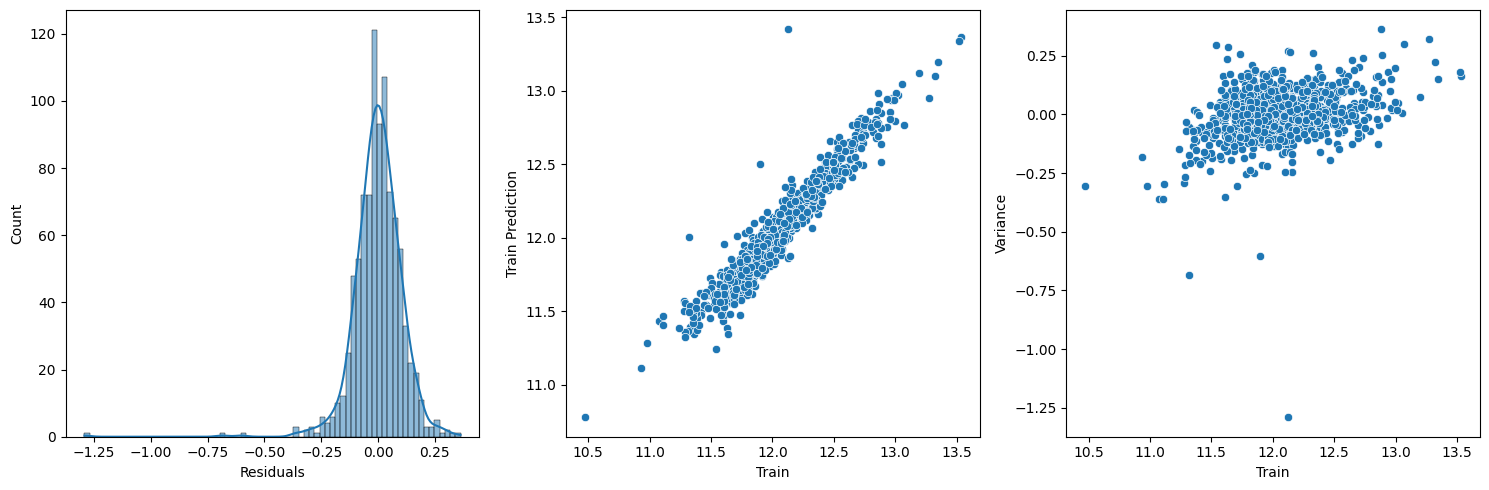

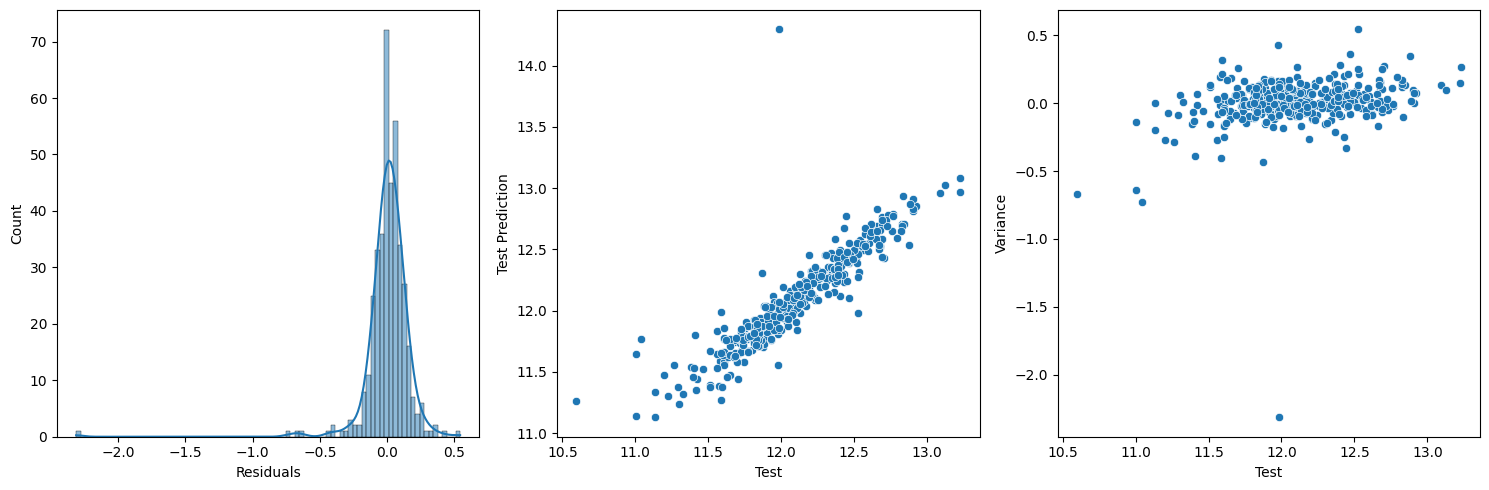

In [105]:
res = y_m2_train - y_m2_pred_train

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
sns.scatterplot(x=y_m2_train, y=y_m2_pred_train, ax=axes[1]).set(xlabel="Train", ylabel="Train Prediction")
sns.scatterplot(x=y_m2_train, y=(y_m2_train-y_m2_pred_train), ax=axes[2]).set(xlabel="Train", ylabel="Variance")

plt.show()

res = y_m2_test - y_m2_pred_test

plt.rcParams["figure.figsize"] = [15, 5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)
try:
    sns.histplot(res,kde=True, ax=axes[0]).set(xlabel="Residuals")
except Exception as e:
    print(f"Can not plot residual for test data. Reason : {e}")    

sns.scatterplot(x=y_m2_test, y=y_m2_pred_test, ax=axes[1]).set(xlabel="Test", ylabel="Test Prediction")
sns.scatterplot(x=y_m2_test, y=(y_m2_test-y_m2_pred_test), ax=axes[2]).set(xlabel="Test", ylabel="Variance")

plt.show()

#### Lasso Regression - Summary

Just like Ridge, Lasso is also able to build decent model which works well on train data with R2 score of 0.91 and on test data with R2 score of 0.80. 

However unlike Ridge, it found hyperparameter being 0 for many of the variables. the further section will have details.


#### Summary Statistics

In [106]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test)'], 
        'Linear Regression': metric
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(metric2, name = 'Ridge Regression')
ls_metric = pd.Series(metric3, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

final_metric

,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),9.172987e-01,0.914929,0.915564
1,R2 Score (Test),-8.890447e+19,0.807957,0.806533
2,RSS (Train),1.057077e+01,10.873706,10.792454
3,RSS (Test),5.495419e+21,11.870668,11.958713
4,MSE (Train),1.062712e-01,0.107783,0.107380
5,MSE (Test),3.697323e+09,0.171840,0.172476


In [107]:
betas = pd.DataFrame(index=X_m2.columns)
betas.rows = X_m2.columns
betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
pd.set_option('display.max_rows', None)
betas

,Linear,Ridge,Lasso
LotFrontage,8.628982e-03,0.010633,0.009803
LotArea,2.065414e-02,0.018371,0.020617
MasVnrArea,3.071074e-04,0.005493,0.000632
BsmtFinSF1,1.329218e-02,0.021306,0.019150
BsmtUnfSF,-1.873693e-02,-0.008590,-0.011965
TotalBsmtSF,4.614627e-02,0.027233,0.031643
1stFlrSF,-3.806845e-02,0.026164,0.000000
2ndFlrSF,-1.980405e-02,0.022053,0.009329
GrLivArea,1.140238e-01,0.038917,0.079116
GarageYrBlt,-1.611601e-02,-0.006192,-0.007695


In [108]:
betas[betas['Lasso'] != 0].shape

(108, 3)

#### Summary

Model 2 has **154** variables and Linear Regression clearly resulted into overfitting.

The R2, RSS, and MSE scores are bit better than Model1 but at the cost of much greater complexity.

Also Ridge and Lasso regressions take much higher time to build such complex model.

Lasso could reduce the variables to **108** by deriving their hyperparameter to 0 however they are still way higher (roughly 2.5 times) than Model 1

## Exercise Summary

In the above exercise we performed EDA, Model Building using linear, ridge and lasso with two variety of independent variables set.

Based on the statistics and the complexity of model, we would choose Model1 for our purpose of prediction. As it's much less complex (having lesser independent variables) despite having almost similar scores as the high complexity model  : Model2